In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model

## Loading Data

In [16]:
def load_data():
    #first we load the MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    #one hot vectorizing the labels
    Y_train_oneHot = tf.one_hot(Y_train, 10)
    Y_test_oneHot = tf.one_hot(Y_test, 10)
    
    #adding channel to the samples
    X_train_channeled = np.reshape(X_train, (X_train.shape[0], 
                                             X_train.shape[1], 
                                             X_train.shape[2], 1))
    X_test_channeled = np.reshape(X_test, (X_test.shape[0], 
                                            X_test.shape[1], 
                                            X_test.shape[2], 1))
    return X_train_channeled, X_test_channeled, Y_train_oneHot, Y_test_oneHot

## Generative Model Using Deep Convolutional Architecture

In [17]:
def generative_model():

    depth = 256
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    x = layers.Dense(7*7*256, name = "FullyConnected_Network_1")(generator_input)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_1")(x)
    x = layers.Activation("relu", name = "Relu_Activation_1")(x)

    x = layers.Reshape((7, 7, depth), name = "Reshaping_2")(x)
    x = layers.Dropout(0.4, name = "Inverse_Dropout_Regularizer_2")(x)

    
    x = layers.UpSampling2D(name = "Upsampling_3")(x)
    x = layers.Conv2DTranspose(int(depth/2), 5, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_3")(x)
    x = layers.Activation("relu", name = "Relu_Activation_3")(x)

    
    x = layers.UpSampling2D(name = "UpSampling_4")(x)
    x = layers.Conv2DTranspose(int(depth/4), 5, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_4")(x)
    x = layers.Activation("relu", name = "Relu_Activation_4")(x)

    
    x = layers.Conv2DTranspose(int(depth/8), 5, padding = "same", name = "Conv_Layer_5")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_5")(x)
    x = layers.Activation("relu", name = "Relu_Activation_5")(x)
    
    x = layers.Conv2DTranspose(1, 5, padding = "same", name = "1_Node_Output_6")(x)
    generator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_6")(x)
#     model.summary()
    
    return keras.Model(generator_input, generator_output, name = "Generator_Model")

Testing The Generator Function

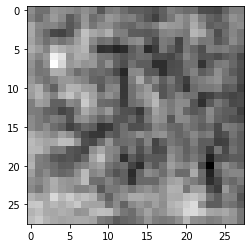

In [18]:
def generator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
    plt.imshow(test_image[0, :, :, 0], cmap='gray')

generator_test()

## Discriminative Model Using Deep Convolutional Architecture

In [19]:
def discriminative_model():
    depth = 64
    dropout = 0.4
    
#     input_shape = input_image_shape #it should be 28*28*1
    discriminator_input = keras.Input(shape = (28, 28, 1), name = "Image_Input")
    x = Conv2D(depth * 1, 5, strides = 2, padding = "same", name = "Conv_Layer_1")(discriminator_input)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_1")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_1")(x)

    x = layers.Conv2D(depth * 2, 5, strides = 2, padding = "same", name = "Conv_Layer_2")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_2")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_2")(x)

    x = layers.Conv2D(depth * 4, 5, strides = 2, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_3")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_3")(x)

    x = layers.Conv2D(depth * 8, 5, strides = 1, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_4")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_4")(x)    

    x = layers.Flatten(name = "FullyConnected_Network_5")(x)
    x = layers.Dense(1, name = "1_Node_Output_5")(x)
    discriminator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_5")(x)

    return keras.Model(discriminator_input, discriminator_output, name = "Discriminator_Model")

In [20]:
def discriminator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    discriminator = discriminative_model()
    output_class = discriminator(test_image, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
        output_class = sess.run(output_class)
    print(output_class)

discriminator_test()

[[0.4963717]]


## Adding Discriminator and Adversarial Loss 

In [22]:
def discriminator_loss():
    discriminator_model = discriminative_model()
    discriminator = keras.models.Sequential()
    discriminator.add(discriminator_model)
    discriminator_model.summary()
    print("\n\n\n")
    discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, 
                                                       decay=6e-8)
    
    discriminator.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                          optimizer = discriminator_optimizer, 
                          metrics = ["accuracy"])
    return discriminator, discriminator_model

def generator_loss(discriminator):
    generator_model = generative_model()
    generator_model.summary()
    print("\n\n\n")
    
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    generator_to_discriminator = generator_model(generator_input)
    attaching_discriminator = discriminator(generator_to_discriminator)
    attached_model = keras.Model(generator_input, attaching_discriminator, name = "Adversarial_Model")
    attached_model.summary()
    print("\n\n\n")
    generator_optimizer = keras.optimizers.RMSprop(lr=0.0004,
                                                   decay=3e-8)

    attached_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                           optimizer = generator_optimizer, 
                           metrics = ["accuracy"])
    return attached_model, generator_model

## Preparing The Models

In [27]:
discriminator_compilation, discriminator_model = discriminator_loss()
generator_compilation, generator_model = generator_loss(discriminator_model)

Model: "Discriminator_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_Layer_1 (Conv2D)        (None, 14, 14, 64)        1664      
_________________________________________________________________
LeakyRelu_Activation_1 (Leak (None, 14, 14, 64)        0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 14, 14, 64)        0         
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 7, 7, 128)         204928    
_________________________________________________________________
LeakyRelu_Activation_2 (Leak (None, 7, 7, 128)         0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 7, 7, 128) 

## Running The Optimization

We run discriminator optimization 5 times more as it is the upper bound of the adversarial optimization (GAN paper for more information). In DCGAN paper it was not mandatory, but in this experiment based on used hyperparameters the discriminator was limitting the adversarial network optimization.

'epoch:  0 ' [discriminator loss:  1.3579991  and acc:  0.5 ] [generator loss:  0.00033368284  and acc:  1.0 ]


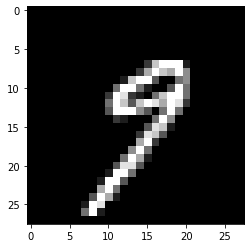

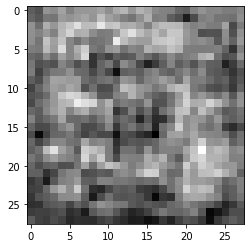

'epoch:  1 ' [discriminator loss:  53.542435  and acc:  0.5 ] [generator loss:  1.2054881  and acc:  0.0 ]
'epoch:  2 ' [discriminator loss:  5.0756927  and acc:  0.5 ] [generator loss:  0.2340968  and acc:  1.0 ]
'epoch:  3 ' [discriminator loss:  1.7446039  and acc:  0.5 ] [generator loss:  0.0070820693  and acc:  1.0 ]
'epoch:  4 ' [discriminator loss:  0.77824205  and acc:  0.5 ] [generator loss:  0.017902568  and acc:  1.0 ]
'epoch:  5 ' [discriminator loss:  0.5564773  and acc:  0.5 ] [generator loss:  0.011736855  and acc:  1.0 ]
'epoch:  6 ' [discriminator loss:  0.43107817  and acc:  0.5 ] [generator loss:  0.0077563794  and acc:  1.0 ]
'epoch:  7 ' [discriminator loss:  0.36792475  and acc:  0.5 ] [generator loss:  0.0034676073  and acc:  1.0 ]
'epoch:  8 ' [discriminator loss:  0.34440508  and acc:  0.8652344 ] [generator loss:  0.0021001068  and acc:  1.0 ]
'epoch:  9 ' [discriminator loss:  0.33399692  and acc:  1.0 ] [generator loss:  0.0013616343  and acc:  1.0 ]
'epoch:

'epoch:  74 ' [discriminator loss:  1.1466348  and acc:  0.5 ] [generator loss:  0.5180278  and acc:  0.90625 ]
'epoch:  75 ' [discriminator loss:  1.1312113  and acc:  0.5 ] [generator loss:  0.5180963  and acc:  0.8828125 ]
'epoch:  76 ' [discriminator loss:  1.0905395  and acc:  0.5 ] [generator loss:  0.57131803  and acc:  0.78515625 ]
'epoch:  77 ' [discriminator loss:  1.0622311  and acc:  0.5 ] [generator loss:  0.57269645  and acc:  0.8125 ]
'epoch:  78 ' [discriminator loss:  1.0032067  and acc:  0.5 ] [generator loss:  0.5823223  and acc:  0.79296875 ]
'epoch:  79 ' [discriminator loss:  0.910599  and acc:  0.5 ] [generator loss:  0.5984694  and acc:  0.765625 ]
'epoch:  80 ' [discriminator loss:  0.8681696  and acc:  0.5 ] [generator loss:  0.6009133  and acc:  0.7734375 ]
'epoch:  81 ' [discriminator loss:  0.86852086  and acc:  0.5 ] [generator loss:  0.6233421  and acc:  0.6953125 ]
'epoch:  82 ' [discriminator loss:  0.80438685  and acc:  0.49804688 ] [generator loss:  0

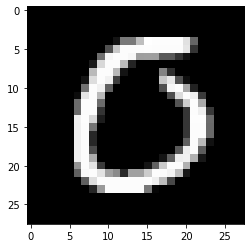

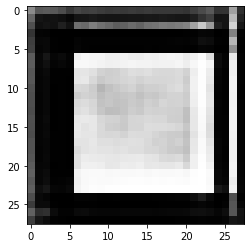

'epoch:  101 ' [discriminator loss:  0.6153151  and acc:  0.5 ] [generator loss:  0.630866  and acc:  0.8359375 ]
'epoch:  102 ' [discriminator loss:  0.57895905  and acc:  0.5 ] [generator loss:  0.61501914  and acc:  0.93359375 ]
'epoch:  103 ' [discriminator loss:  0.55394936  and acc:  0.5 ] [generator loss:  0.63934207  and acc:  0.79296875 ]
'epoch:  104 ' [discriminator loss:  0.54693556  and acc:  0.5 ] [generator loss:  0.64341676  and acc:  0.78515625 ]
'epoch:  105 ' [discriminator loss:  0.51598024  and acc:  0.5 ] [generator loss:  0.64402086  and acc:  0.78125 ]
'epoch:  106 ' [discriminator loss:  0.5128567  and acc:  0.5 ] [generator loss:  0.6386874  and acc:  0.8203125 ]
'epoch:  107 ' [discriminator loss:  0.50294566  and acc:  0.5 ] [generator loss:  0.63648987  and acc:  0.84765625 ]
'epoch:  108 ' [discriminator loss:  0.4992402  and acc:  0.5 ] [generator loss:  0.6467087  and acc:  0.8671875 ]
'epoch:  109 ' [discriminator loss:  0.51198024  and acc:  0.49804688

'epoch:  172 ' [discriminator loss:  0.403656  and acc:  0.5 ] [generator loss:  0.8097413  and acc:  0.0 ]
'epoch:  173 ' [discriminator loss:  0.37926245  and acc:  0.5175781 ] [generator loss:  0.8188772  and acc:  0.00390625 ]
'epoch:  174 ' [discriminator loss:  0.38833824  and acc:  0.51171875 ] [generator loss:  0.81920075  and acc:  0.0 ]
'epoch:  175 ' [discriminator loss:  0.3761032  and acc:  0.5234375 ] [generator loss:  0.8389764  and acc:  0.0 ]
'epoch:  176 ' [discriminator loss:  0.35180175  and acc:  0.6855469 ] [generator loss:  0.82655406  and acc:  0.0 ]
'epoch:  177 ' [discriminator loss:  0.3918452  and acc:  0.6738281 ] [generator loss:  0.72047997  and acc:  0.23046875 ]
'epoch:  178 ' [discriminator loss:  0.49514896  and acc:  0.5 ] [generator loss:  0.7915726  and acc:  0.0 ]
'epoch:  179 ' [discriminator loss:  0.47305584  and acc:  0.5 ] [generator loss:  0.826049  and acc:  0.0 ]
'epoch:  180 ' [discriminator loss:  0.4696201  and acc:  0.5 ] [generator lo

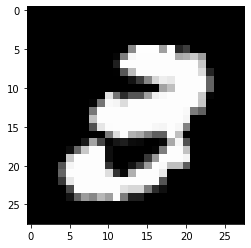

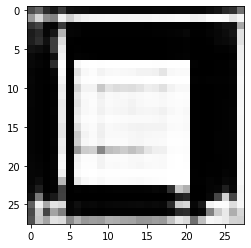

'epoch:  201 ' [discriminator loss:  0.35247752  and acc:  0.6699219 ] [generator loss:  0.8413342  and acc:  0.0 ]
'epoch:  202 ' [discriminator loss:  0.35688472  and acc:  0.6191406 ] [generator loss:  0.845644  and acc:  0.0 ]
'epoch:  203 ' [discriminator loss:  0.3462625  and acc:  0.7402344 ] [generator loss:  0.8590082  and acc:  0.0 ]
'epoch:  204 ' [discriminator loss:  0.34417188  and acc:  0.8066406 ] [generator loss:  0.8472483  and acc:  0.0 ]
'epoch:  205 ' [discriminator loss:  0.46424502  and acc:  0.5 ] [generator loss:  0.90560454  and acc:  0.0 ]
'epoch:  206 ' [discriminator loss:  0.34930694  and acc:  0.73046875 ] [generator loss:  0.90035146  and acc:  0.0 ]
'epoch:  207 ' [discriminator loss:  0.36533093  and acc:  0.5878906 ] [generator loss:  0.9298042  and acc:  0.0 ]
'epoch:  208 ' [discriminator loss:  0.3209814  and acc:  0.9863281 ] [generator loss:  0.9290341  and acc:  0.0 ]
'epoch:  209 ' [discriminator loss:  0.31338894  and acc:  1.0 ] [generator lo

'epoch:  274 ' [discriminator loss:  0.6247118  and acc:  0.5 ] [generator loss:  0.5774976  and acc:  1.0 ]
'epoch:  275 ' [discriminator loss:  0.60620415  and acc:  0.5 ] [generator loss:  0.57471764  and acc:  1.0 ]
'epoch:  276 ' [discriminator loss:  0.57990324  and acc:  0.5 ] [generator loss:  0.5729494  and acc:  1.0 ]
'epoch:  277 ' [discriminator loss:  0.5864422  and acc:  0.5 ] [generator loss:  0.57150614  and acc:  1.0 ]
'epoch:  278 ' [discriminator loss:  0.57797927  and acc:  0.5 ] [generator loss:  0.57651913  and acc:  0.99609375 ]
'epoch:  279 ' [discriminator loss:  0.56908035  and acc:  0.5 ] [generator loss:  0.59013516  and acc:  0.99609375 ]
'epoch:  280 ' [discriminator loss:  0.5572194  and acc:  0.5 ] [generator loss:  0.6001292  and acc:  0.98828125 ]
'epoch:  281 ' [discriminator loss:  0.55672836  and acc:  0.5 ] [generator loss:  0.60524106  and acc:  0.98828125 ]
'epoch:  282 ' [discriminator loss:  0.54260504  and acc:  0.5 ] [generator loss:  0.62271

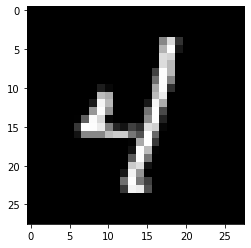

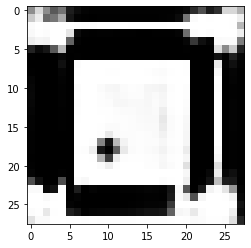

'epoch:  301 ' [discriminator loss:  0.8564188  and acc:  0.5 ] [generator loss:  0.8484942  and acc:  0.03125 ]
'epoch:  302 ' [discriminator loss:  0.62154764  and acc:  0.5 ] [generator loss:  0.8752083  and acc:  0.0078125 ]
'epoch:  303 ' [discriminator loss:  0.50493085  and acc:  0.5 ] [generator loss:  0.8403576  and acc:  0.01953125 ]
'epoch:  304 ' [discriminator loss:  0.49002934  and acc:  0.5 ] [generator loss:  0.85598433  and acc:  0.0 ]
'epoch:  305 ' [discriminator loss:  0.43424314  and acc:  0.5 ] [generator loss:  0.8200982  and acc:  0.03125 ]
'epoch:  306 ' [discriminator loss:  0.48543966  and acc:  0.5 ] [generator loss:  0.8512684  and acc:  0.01953125 ]
'epoch:  307 ' [discriminator loss:  0.4354108  and acc:  0.5 ] [generator loss:  0.8051201  and acc:  0.04296875 ]
'epoch:  308 ' [discriminator loss:  0.46919388  and acc:  0.5 ] [generator loss:  0.85151976  and acc:  0.01171875 ]
'epoch:  309 ' [discriminator loss:  0.44310236  and acc:  0.5019531 ] [genera

'epoch:  373 ' [discriminator loss:  5.693388  and acc:  0.5 ] [generator loss:  0.008350836  and acc:  1.0 ]
'epoch:  374 ' [discriminator loss:  3.473031  and acc:  0.5 ] [generator loss:  0.12649369  and acc:  0.9921875 ]
'epoch:  375 ' [discriminator loss:  6.7027645  and acc:  0.5 ] [generator loss:  0.0021194685  and acc:  1.0 ]
'epoch:  376 ' [discriminator loss:  4.0106277  and acc:  0.5 ] [generator loss:  0.06173478  and acc:  1.0 ]
'epoch:  377 ' [discriminator loss:  5.319637  and acc:  0.5 ] [generator loss:  0.016285025  and acc:  1.0 ]
'epoch:  378 ' [discriminator loss:  3.7306428  and acc:  0.5 ] [generator loss:  0.119322  and acc:  0.9921875 ]
'epoch:  379 ' [discriminator loss:  7.097146  and acc:  0.5 ] [generator loss:  0.0015613066  and acc:  1.0 ]
'epoch:  380 ' [discriminator loss:  3.8637934  and acc:  0.49804688 ] [generator loss:  0.06133224  and acc:  1.0 ]
'epoch:  381 ' [discriminator loss:  5.1920195  and acc:  0.49804688 ] [generator loss:  0.02214824  

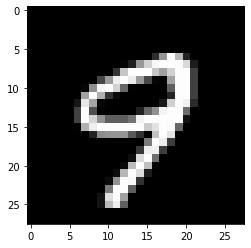

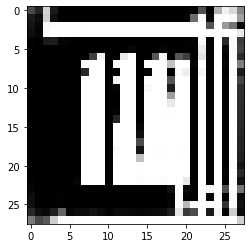

'epoch:  401 ' [discriminator loss:  4.3674517  and acc:  0.5 ] [generator loss:  0.11026495  and acc:  1.0 ]
'epoch:  402 ' [discriminator loss:  2.4181912  and acc:  0.5 ] [generator loss:  0.7775832  and acc:  0.484375 ]
'epoch:  403 ' [discriminator loss:  3.7266355  and acc:  0.5 ] [generator loss:  0.17841741  and acc:  0.99609375 ]
'epoch:  404 ' [discriminator loss:  2.5723248  and acc:  0.5 ] [generator loss:  0.62660545  and acc:  0.6328125 ]
'epoch:  405 ' [discriminator loss:  3.0825617  and acc:  0.5 ] [generator loss:  0.3003977  and acc:  0.96484375 ]
'epoch:  406 ' [discriminator loss:  2.3239007  and acc:  0.5 ] [generator loss:  0.7716592  and acc:  0.5234375 ]
'epoch:  407 ' [discriminator loss:  2.7072294  and acc:  0.5 ] [generator loss:  0.41433322  and acc:  0.890625 ]
'epoch:  408 ' [discriminator loss:  2.3555582  and acc:  0.5 ] [generator loss:  0.8252907  and acc:  0.4609375 ]
'epoch:  409 ' [discriminator loss:  2.543709  and acc:  0.5 ] [generator loss:  0

'epoch:  471 ' [discriminator loss:  0.58978283  and acc:  0.5371094 ] [generator loss:  1.9355471  and acc:  0.00390625 ]
'epoch:  472 ' [discriminator loss:  0.8113549  and acc:  0.51953125 ] [generator loss:  1.3566686  and acc:  0.0625 ]
'epoch:  473 ' [discriminator loss:  0.60700893  and acc:  0.53515625 ] [generator loss:  1.8249745  and acc:  0.00390625 ]
'epoch:  474 ' [discriminator loss:  0.68717945  and acc:  0.5058594 ] [generator loss:  1.3964615  and acc:  0.0625 ]
'epoch:  475 ' [discriminator loss:  0.54096305  and acc:  0.5644531 ] [generator loss:  1.9462571  and acc:  0.0 ]
'epoch:  476 ' [discriminator loss:  1.0415703  and acc:  0.5136719 ] [generator loss:  0.42739904  and acc:  0.8828125 ]
'epoch:  477 ' [discriminator loss:  1.0488596  and acc:  0.5 ] [generator loss:  1.5816901  and acc:  0.01953125 ]
'epoch:  478 ' [discriminator loss:  0.6407087  and acc:  0.5449219 ] [generator loss:  1.6540322  and acc:  0.03515625 ]
'epoch:  479 ' [discriminator loss:  0.

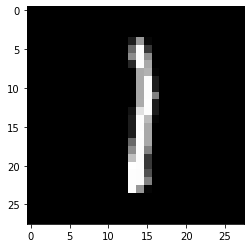

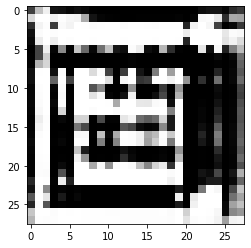

'epoch:  501 ' [discriminator loss:  0.5130875  and acc:  0.66015625 ] [generator loss:  2.8077312  and acc:  0.015625 ]
'epoch:  502 ' [discriminator loss:  0.528758  and acc:  0.6542969 ] [generator loss:  2.9512298  and acc:  0.01953125 ]
'epoch:  503 ' [discriminator loss:  0.5510897  and acc:  0.65625 ] [generator loss:  3.0669665  and acc:  0.015625 ]
'epoch:  504 ' [discriminator loss:  0.39813456  and acc:  0.75 ] [generator loss:  2.571581  and acc:  0.03125 ]
'epoch:  505 ' [discriminator loss:  0.53474396  and acc:  0.73046875 ] [generator loss:  1.863281  and acc:  0.09765625 ]
'epoch:  506 ' [discriminator loss:  0.71800596  and acc:  0.58203125 ] [generator loss:  20.55622  and acc:  0.0 ]
'epoch:  507 ' [discriminator loss:  0.47212327  and acc:  0.7246094 ] [generator loss:  3.3744931  and acc:  0.00390625 ]
'epoch:  508 ' [discriminator loss:  0.40654913  and acc:  0.8691406 ] [generator loss:  2.163509  and acc:  0.08984375 ]
'epoch:  509 ' [discriminator loss:  0.509

'epoch:  571 ' [discriminator loss:  0.11697765  and acc:  0.95703125 ] [generator loss:  8.630497  and acc:  0.0 ]
'epoch:  572 ' [discriminator loss:  0.024376864  and acc:  1.0 ] [generator loss:  5.445652  and acc:  0.0 ]
'epoch:  573 ' [discriminator loss:  0.27785674  and acc:  0.8574219 ] [generator loss:  13.727175  and acc:  0.0 ]
'epoch:  574 ' [discriminator loss:  0.0017949514  and acc:  1.0 ] [generator loss:  6.807117  and acc:  0.0 ]
'epoch:  575 ' [discriminator loss:  0.042732865  and acc:  0.9941406 ] [generator loss:  5.28905  and acc:  0.0 ]
'epoch:  576 ' [discriminator loss:  0.099766746  and acc:  0.984375 ] [generator loss:  5.961797  and acc:  0.0 ]
'epoch:  577 ' [discriminator loss:  0.074333414  and acc:  0.9902344 ] [generator loss:  5.915203  and acc:  0.0 ]
'epoch:  578 ' [discriminator loss:  0.07914645  and acc:  0.98046875 ] [generator loss:  6.1950064  and acc:  0.0 ]
'epoch:  579 ' [discriminator loss:  0.079197034  and acc:  0.98828125 ] [generator 

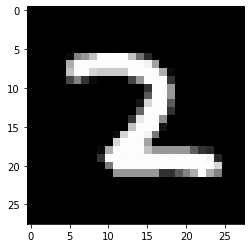

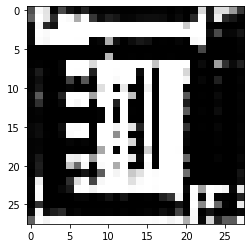

'epoch:  601 ' [discriminator loss:  2.3399012  and acc:  0.5214844 ] [generator loss:  11.682123  and acc:  0.0 ]
'epoch:  602 ' [discriminator loss:  0.22422828  and acc:  0.89453125 ] [generator loss:  10.111652  and acc:  0.0 ]
'epoch:  603 ' [discriminator loss:  0.56884897  and acc:  0.73828125 ] [generator loss:  16.306519  and acc:  0.0 ]
'epoch:  604 ' [discriminator loss:  0.0018185957  and acc:  1.0 ] [generator loss:  7.990987  and acc:  0.0 ]
'epoch:  605 ' [discriminator loss:  1.0994012  and acc:  0.58203125 ] [generator loss:  19.462652  and acc:  0.0 ]
'epoch:  606 ' [discriminator loss:  5.62073e-05  and acc:  1.0 ] [generator loss:  12.135931  and acc:  0.0 ]
'epoch:  607 ' [discriminator loss:  0.01469294  and acc:  0.9980469 ] [generator loss:  6.1028285  and acc:  0.0 ]
'epoch:  608 ' [discriminator loss:  1.0824416  and acc:  0.58203125 ] [generator loss:  16.06857  and acc:  0.0 ]
'epoch:  609 ' [discriminator loss:  0.7010412  and acc:  0.9980469 ] [generator l

'epoch:  672 ' [discriminator loss:  1.3630747  and acc:  0.66796875 ] [generator loss:  25.699266  and acc:  0.0 ]
'epoch:  673 ' [discriminator loss:  0.0010908847  and acc:  1.0 ] [generator loss:  13.604853  and acc:  0.00390625 ]
'epoch:  674 ' [discriminator loss:  1.556706  and acc:  0.73046875 ] [generator loss:  498.08417  and acc:  0.0 ]
'epoch:  675 ' [discriminator loss:  9.884743e-09  and acc:  1.0 ] [generator loss:  28.389328  and acc:  0.0 ]
'epoch:  676 ' [discriminator loss:  4.710158e-06  and acc:  1.0 ] [generator loss:  17.435577  and acc:  0.0 ]
'epoch:  677 ' [discriminator loss:  0.0057095513  and acc:  0.99609375 ] [generator loss:  11.362719  and acc:  0.0 ]
'epoch:  678 ' [discriminator loss:  0.16224551  and acc:  0.9355469 ] [generator loss:  13.040747  and acc:  0.0 ]
'epoch:  679 ' [discriminator loss:  0.083575636  and acc:  0.9589844 ] [generator loss:  11.611655  and acc:  0.00390625 ]
'epoch:  680 ' [discriminator loss:  0.058866877  and acc:  0.98046

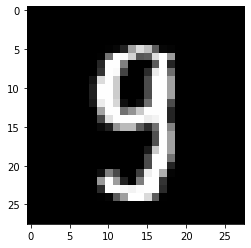

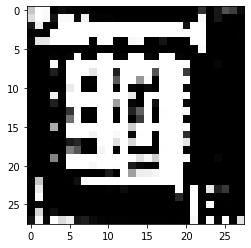

'epoch:  701 ' [discriminator loss:  0.1826064  and acc:  0.9238281 ] [generator loss:  17.197554  and acc:  0.0 ]
'epoch:  702 ' [discriminator loss:  0.00019135972  and acc:  1.0 ] [generator loss:  11.904636  and acc:  0.0 ]
'epoch:  703 ' [discriminator loss:  0.012356872  and acc:  0.9941406 ] [generator loss:  8.313408  and acc:  0.0 ]
'epoch:  704 ' [discriminator loss:  0.12098414  and acc:  0.9511719 ] [generator loss:  13.855841  and acc:  0.0 ]
'epoch:  705 ' [discriminator loss:  0.0009646851  and acc:  1.0 ] [generator loss:  9.431027  and acc:  0.0 ]
'epoch:  706 ' [discriminator loss:  0.042971127  and acc:  0.9863281 ] [generator loss:  9.853094  and acc:  0.0 ]
'epoch:  707 ' [discriminator loss:  0.055123642  and acc:  0.98046875 ] [generator loss:  11.000853  and acc:  0.0 ]
'epoch:  708 ' [discriminator loss:  0.008568673  and acc:  1.0 ] [generator loss:  7.2322617  and acc:  0.0 ]
'epoch:  709 ' [discriminator loss:  0.19795354  and acc:  0.9082031 ] [generator lo

'epoch:  772 ' [discriminator loss:  0.28456783  and acc:  0.9824219 ] [generator loss:  8.267092  and acc:  0.0 ]
'epoch:  773 ' [discriminator loss:  0.9151773  and acc:  0.6425781 ] [generator loss:  23.620396  and acc:  0.0 ]
'epoch:  774 ' [discriminator loss:  2.311736e-06  and acc:  1.0 ] [generator loss:  15.970312  and acc:  0.0 ]
'epoch:  775 ' [discriminator loss:  0.000947207  and acc:  1.0 ] [generator loss:  8.5305  and acc:  0.0 ]
'epoch:  776 ' [discriminator loss:  0.62815607  and acc:  0.7207031 ] [generator loss:  19.533207  and acc:  0.0 ]
'epoch:  777 ' [discriminator loss:  6.456688e-05  and acc:  1.0 ] [generator loss:  11.700747  and acc:  0.0 ]
'epoch:  778 ' [discriminator loss:  0.043801412  and acc:  0.9921875 ] [generator loss:  7.057729  and acc:  0.0 ]
'epoch:  779 ' [discriminator loss:  0.9862954  and acc:  0.6113281 ] [generator loss:  22.651867  and acc:  0.0 ]
'epoch:  780 ' [discriminator loss:  9.660683e-06  and acc:  1.0 ] [generator loss:  15.171

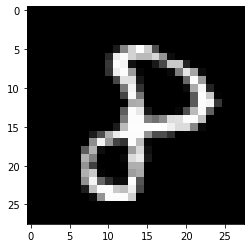

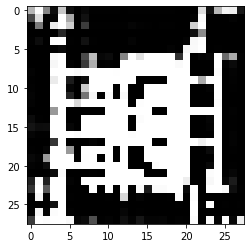

'epoch:  801 ' [discriminator loss:  0.8019017  and acc:  0.6660156 ] [generator loss:  23.42208  and acc:  0.0 ]
'epoch:  802 ' [discriminator loss:  6.304858e-06  and acc:  1.0 ] [generator loss:  15.352905  and acc:  0.0 ]
'epoch:  803 ' [discriminator loss:  0.005196262  and acc:  1.0 ] [generator loss:  7.7091637  and acc:  0.0 ]
'epoch:  804 ' [discriminator loss:  0.80567133  and acc:  0.6777344 ] [generator loss:  22.012901  and acc:  0.0 ]
'epoch:  805 ' [discriminator loss:  0.5986756  and acc:  0.9980469 ] [generator loss:  15.544046  and acc:  0.0 ]
'epoch:  806 ' [discriminator loss:  0.031690914  and acc:  0.9902344 ] [generator loss:  7.314179  and acc:  0.0078125 ]
'epoch:  807 ' [discriminator loss:  1.8673607  and acc:  0.54296875 ] [generator loss:  30.450785  and acc:  0.0 ]
'epoch:  808 ' [discriminator loss:  1.5219109e-06  and acc:  1.0 ] [generator loss:  20.162956  and acc:  0.0 ]
'epoch:  809 ' [discriminator loss:  0.00093058636  and acc:  1.0 ] [generator lo

'epoch:  873 ' [discriminator loss:  0.68395257  and acc:  0.82421875 ] [generator loss:  24.715675  and acc:  0.0 ]
'epoch:  874 ' [discriminator loss:  0.009623617  and acc:  0.99609375 ] [generator loss:  14.004142  and acc:  0.00390625 ]
'epoch:  875 ' [discriminator loss:  0.7850498  and acc:  0.7988281 ] [generator loss:  28.844172  and acc:  0.0 ]
'epoch:  876 ' [discriminator loss:  0.0006923507  and acc:  1.0 ] [generator loss:  16.964275  and acc:  0.00390625 ]
'epoch:  877 ' [discriminator loss:  0.32040763  and acc:  0.90234375 ] [generator loss:  18.80642  and acc:  0.0 ]
'epoch:  878 ' [discriminator loss:  0.23604038  and acc:  0.9316406 ] [generator loss:  16.059431  and acc:  0.0078125 ]
'epoch:  879 ' [discriminator loss:  0.43818694  and acc:  0.8652344 ] [generator loss:  23.682793  and acc:  0.0 ]
'epoch:  880 ' [discriminator loss:  0.012790493  and acc:  0.99609375 ] [generator loss:  12.957434  and acc:  0.01953125 ]
'epoch:  881 ' [discriminator loss:  1.090569

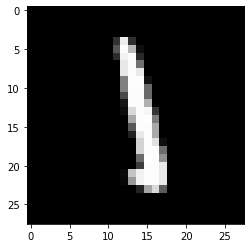

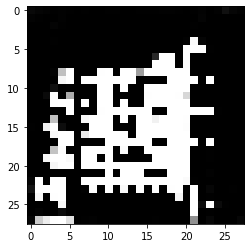

'epoch:  901 ' [discriminator loss:  1.2017281  and acc:  0.765625 ] [generator loss:  41.80034  and acc:  0.0 ]
'epoch:  902 ' [discriminator loss:  5.0564597e-07  and acc:  1.0 ] [generator loss:  26.358118  and acc:  0.0 ]
'epoch:  903 ' [discriminator loss:  0.0821304  and acc:  0.9746094 ] [generator loss:  17.119122  and acc:  0.0078125 ]
'epoch:  904 ' [discriminator loss:  1.643696  and acc:  0.7050781 ] [generator loss:  47.70701  and acc:  0.0 ]
'epoch:  905 ' [discriminator loss:  1.6263718e-06  and acc:  1.0 ] [generator loss:  30.38187  and acc:  0.0 ]
'epoch:  906 ' [discriminator loss:  0.24993023  and acc:  0.9433594 ] [generator loss:  25.694866  and acc:  0.0 ]
'epoch:  907 ' [discriminator loss:  0.65463775  and acc:  0.8730469 ] [generator loss:  36.949265  and acc:  0.0 ]
'epoch:  908 ' [discriminator loss:  0.00044253343  and acc:  1.0 ] [generator loss:  20.496117  and acc:  0.0 ]
'epoch:  909 ' [discriminator loss:  0.39564866  and acc:  0.8808594 ] [generator l

'epoch:  973 ' [discriminator loss:  5.26031  and acc:  0.5761719 ] [generator loss:  82.23645  and acc:  0.0 ]
'epoch:  974 ' [discriminator loss:  2.4945437e-18  and acc:  1.0 ] [generator loss:  59.603172  and acc:  0.0 ]
'epoch:  975 ' [discriminator loss:  1.1670592e-12  and acc:  1.0 ] [generator loss:  45.79186  and acc:  0.0 ]
'epoch:  976 ' [discriminator loss:  3.296482e-08  and acc:  1.0 ] [generator loss:  30.749622  and acc:  0.0 ]
'epoch:  977 ' [discriminator loss:  0.0036300616  and acc:  1.0 ] [generator loss:  16.000483  and acc:  0.01171875 ]
'epoch:  978 ' [discriminator loss:  3.084941  and acc:  0.59375 ] [generator loss:  60.04265  and acc:  0.0 ]
'epoch:  979 ' [discriminator loss:  4.7272825e-13  and acc:  1.0 ] [generator loss:  43.67698  and acc:  0.0 ]
'epoch:  980 ' [discriminator loss:  1.7472784e-08  and acc:  1.0 ] [generator loss:  29.910149  and acc:  0.0 ]
'epoch:  981 ' [discriminator loss:  0.06437944  and acc:  0.9785156 ] [generator loss:  18.6373

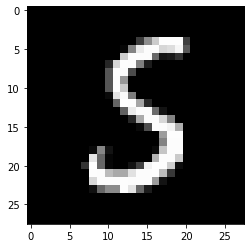

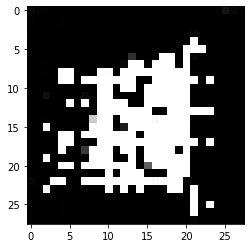

'epoch:  1001 ' [discriminator loss:  1.3001894  and acc:  0.75 ] [generator loss:  45.29258  and acc:  0.0 ]
'epoch:  1002 ' [discriminator loss:  1.1831315e-08  and acc:  1.0 ] [generator loss:  28.854351  and acc:  0.0 ]
'epoch:  1003 ' [discriminator loss:  0.09591307  and acc:  0.9628906 ] [generator loss:  21.85775  and acc:  0.0 ]
'epoch:  1004 ' [discriminator loss:  0.37848336  and acc:  0.9277344 ] [generator loss:  27.711195  and acc:  0.0 ]
'epoch:  1005 ' [discriminator loss:  0.056585  and acc:  0.9824219 ] [generator loss:  16.300694  and acc:  0.0 ]
'epoch:  1006 ' [discriminator loss:  2.3927715  and acc:  0.64453125 ] [generator loss:  48.666565  and acc:  0.0 ]
'epoch:  1007 ' [discriminator loss:  0.0019302538  and acc:  1.0 ] [generator loss:  26.90651  and acc:  0.00390625 ]
'epoch:  1008 ' [discriminator loss:  14.834987  and acc:  0.96875 ] [generator loss:  11.572946  and acc:  0.1328125 ]
'epoch:  1009 ' [discriminator loss:  5.3022995  and acc:  0.5410156 ] [

'epoch:  1071 ' [discriminator loss:  5.3543573e-08  and acc:  1.0 ] [generator loss:  53.115517  and acc:  0.0 ]
'epoch:  1072 ' [discriminator loss:  0.1919648  and acc:  0.9667969 ] [generator loss:  37.882965  and acc:  0.00390625 ]
'epoch:  1073 ' [discriminator loss:  2.0282316  and acc:  0.8027344 ] [generator loss:  87.162224  and acc:  0.0 ]
'epoch:  1074 ' [discriminator loss:  4.6122076e-14  and acc:  1.0 ] [generator loss:  64.220085  and acc:  0.0 ]
'epoch:  1075 ' [discriminator loss:  0.37508792  and acc:  0.9980469 ] [generator loss:  32.339912  and acc:  0.01171875 ]
'epoch:  1076 ' [discriminator loss:  4.9795294  and acc:  0.6699219 ] [generator loss:  107.96037  and acc:  0.0 ]
'epoch:  1077 ' [discriminator loss:  1.2086234e-12  and acc:  1.0 ] [generator loss:  76.5775  and acc:  0.0 ]
'epoch:  1078 ' [discriminator loss:  0.03426285  and acc:  0.9941406 ] [generator loss:  45.477036  and acc:  0.01171875 ]
'epoch:  1079 ' [discriminator loss:  5.1061916  and acc:

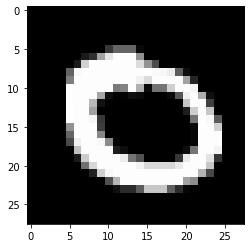

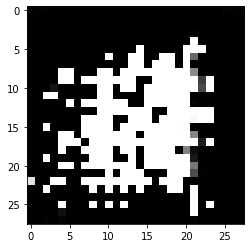

'epoch:  1101 ' [discriminator loss:  0.006683392  and acc:  0.99609375 ] [generator loss:  55.632065  and acc:  0.0 ]
'epoch:  1102 ' [discriminator loss:  0.43223292  and acc:  0.9375 ] [generator loss:  55.3895  and acc:  0.0 ]
'epoch:  1103 ' [discriminator loss:  0.277075  and acc:  0.9628906 ] [generator loss:  42.092915  and acc:  0.015625 ]
'epoch:  1104 ' [discriminator loss:  1.0462787  and acc:  0.8730469 ] [generator loss:  72.784935  and acc:  0.0 ]
'epoch:  1105 ' [discriminator loss:  0.0019161883  and acc:  0.9980469 ] [generator loss:  42.745102  and acc:  0.0078125 ]
'epoch:  1106 ' [discriminator loss:  1.9109663  and acc:  0.8339844 ] [generator loss:  81.8825  and acc:  0.0 ]
'epoch:  1107 ' [discriminator loss:  0.21932228  and acc:  0.96875 ] [generator loss:  63.015858  and acc:  0.0 ]
'epoch:  1108 ' [discriminator loss:  2.5488453  and acc:  0.7714844 ] [generator loss:  141.01155  and acc:  0.0 ]
'epoch:  1109 ' [discriminator loss:  4.1197524e-21  and acc:  

'epoch:  1172 ' [discriminator loss:  0.028326442  and acc:  0.99609375 ] [generator loss:  56.69196  and acc:  0.0078125 ]
'epoch:  1173 ' [discriminator loss:  6.1356564  and acc:  0.6875 ] [generator loss:  139.78683  and acc:  0.0 ]
'epoch:  1174 ' [discriminator loss:  5.743841e-19  and acc:  1.0 ] [generator loss:  96.78998  and acc:  0.0 ]
'epoch:  1175 ' [discriminator loss:  0.030828264  and acc:  0.9980469 ] [generator loss:  55.90445  and acc:  0.00390625 ]
'epoch:  1176 ' [discriminator loss:  2.719697  and acc:  0.80859375 ] [generator loss:  101.2325  and acc:  0.0 ]
'epoch:  1177 ' [discriminator loss:  0.014513448  and acc:  0.9980469 ] [generator loss:  56.758507  and acc:  0.0078125 ]
'epoch:  1178 ' [discriminator loss:  1.3182656  and acc:  0.86328125 ] [generator loss:  74.14316  and acc:  0.0 ]
'epoch:  1179 ' [discriminator loss:  0.22123632  and acc:  0.9667969 ] [generator loss:  48.27568  and acc:  0.00390625 ]
'epoch:  1180 ' [discriminator loss:  3.1123328  

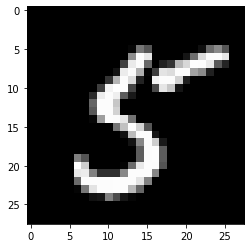

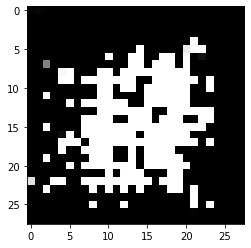

'epoch:  1201 ' [discriminator loss:  5.138372  and acc:  0.703125 ] [generator loss:  190.51768  and acc:  0.0 ]
'epoch:  1202 ' [discriminator loss:  1.4684933e-33  and acc:  1.0 ] [generator loss:  140.64215  and acc:  0.0 ]
'epoch:  1203 ' [discriminator loss:  0.00020973943  and acc:  1.0 ] [generator loss:  81.091385  and acc:  0.0 ]
'epoch:  1204 ' [discriminator loss:  0.87918025  and acc:  0.92578125 ] [generator loss:  108.85002  and acc:  0.0 ]
'epoch:  1205 ' [discriminator loss:  0.00022491609  and acc:  1.0 ] [generator loss:  64.95895  and acc:  0.00390625 ]
'epoch:  1206 ' [discriminator loss:  2.6269894  and acc:  0.8359375 ] [generator loss:  140.18498  and acc:  0.0 ]
'epoch:  1207 ' [discriminator loss:  6.0810563e-22  and acc:  1.0 ] [generator loss:  106.958755  and acc:  0.0 ]
'epoch:  1208 ' [discriminator loss:  4.7077698e-08  and acc:  1.0 ] [generator loss:  69.41055  and acc:  0.0 ]
'epoch:  1209 ' [discriminator loss:  0.13125014  and acc:  0.9785156 ] [gen

'epoch:  1272 ' [discriminator loss:  7.2191486  and acc:  0.6347656 ] [generator loss:  149.08044  and acc:  0.0 ]
'epoch:  1273 ' [discriminator loss:  1.0401463e-09  and acc:  1.0 ] [generator loss:  87.188934  and acc:  0.0 ]
'epoch:  1274 ' [discriminator loss:  1.1824566  and acc:  0.9082031 ] [generator loss:  69.06372  and acc:  0.0 ]
'epoch:  1275 ' [discriminator loss:  3.1147237  and acc:  0.7910156 ] [generator loss:  123.050354  and acc:  0.0 ]
'epoch:  1276 ' [discriminator loss:  0.03786962  and acc:  0.99609375 ] [generator loss:  63.0074  and acc:  0.0 ]
'epoch:  1277 ' [discriminator loss:  5.5443964  and acc:  0.7265625 ] [generator loss:  143.89655  and acc:  0.0 ]
'epoch:  1278 ' [discriminator loss:  0.0008402977  and acc:  1.0 ] [generator loss:  76.808  and acc:  0.0078125 ]
'epoch:  1279 ' [discriminator loss:  5.322116  and acc:  0.7246094 ] [generator loss:  177.92752  and acc:  0.0 ]
'epoch:  1280 ' [discriminator loss:  5.3764406e-06  and acc:  1.0 ] [gener

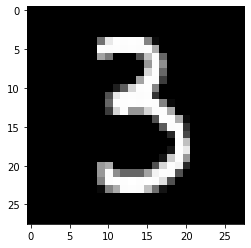

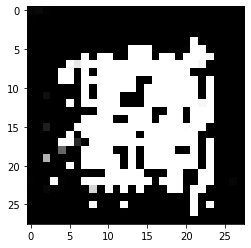

'epoch:  1301 ' [discriminator loss:  4.537115  and acc:  0.81640625 ] [generator loss:  235.75208  and acc:  0.0 ]
'epoch:  1302 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  178.26477  and acc:  0.0 ]
'epoch:  1303 ' [discriminator loss:  1.898332e-13  and acc:  1.0 ] [generator loss:  113.39461  and acc:  0.0 ]
'epoch:  1304 ' [discriminator loss:  0.5021738  and acc:  0.9667969 ] [generator loss:  79.41767  and acc:  0.00390625 ]
'epoch:  1305 ' [discriminator loss:  3.438939  and acc:  0.8222656 ] [generator loss:  159.31137  and acc:  0.0 ]
'epoch:  1306 ' [discriminator loss:  0.0001361366  and acc:  1.0 ] [generator loss:  84.147446  and acc:  0.00390625 ]
'epoch:  1307 ' [discriminator loss:  4.7887335  and acc:  0.7597656 ] [generator loss:  197.13167  and acc:  0.0 ]
'epoch:  1308 ' [discriminator loss:  7.685327e-09  and acc:  1.0 ] [generator loss:  133.45456  and acc:  0.0 ]
'epoch:  1309 ' [discriminator loss:  0.12524621  and acc:  0.99609375 ] [generat

'epoch:  1372 ' [discriminator loss:  8.447798e-18  and acc:  1.0 ] [generator loss:  110.24861  and acc:  0.0 ]
'epoch:  1373 ' [discriminator loss:  1.0584433  and acc:  0.93359375 ] [generator loss:  113.14349  and acc:  0.0 ]
'epoch:  1374 ' [discriminator loss:  0.29205248  and acc:  0.9707031 ] [generator loss:  74.588104  and acc:  0.0 ]
'epoch:  1375 ' [discriminator loss:  6.78094  and acc:  0.7011719 ] [generator loss:  236.45273  and acc:  0.0 ]
'epoch:  1376 ' [discriminator loss:  2.5158345e-33  and acc:  1.0 ] [generator loss:  160.20004  and acc:  0.0 ]
'epoch:  1377 ' [discriminator loss:  9.590642e-05  and acc:  1.0 ] [generator loss:  88.60006  and acc:  0.0 ]
'epoch:  1378 ' [discriminator loss:  2.6066632  and acc:  0.8457031 ] [generator loss:  162.57474  and acc:  0.0 ]
'epoch:  1379 ' [discriminator loss:  0.00094259554  and acc:  1.0 ] [generator loss:  99.311584  and acc:  0.0 ]
'epoch:  1380 ' [discriminator loss:  0.5081686  and acc:  0.95703125 ] [generator 

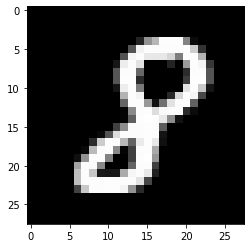

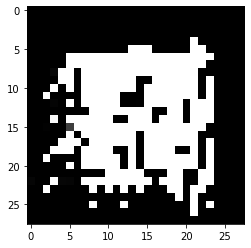

'epoch:  1401 ' [discriminator loss:  5.5994544  and acc:  0.734375 ] [generator loss:  230.55139  and acc:  0.0 ]
'epoch:  1402 ' [discriminator loss:  1.2637848e-25  and acc:  1.0 ] [generator loss:  148.1698  and acc:  0.0 ]
'epoch:  1403 ' [discriminator loss:  0.1528285  and acc:  0.9863281 ] [generator loss:  96.069984  and acc:  0.0078125 ]
'epoch:  1404 ' [discriminator loss:  3.1567874  and acc:  0.8417969 ] [generator loss:  198.47638  and acc:  0.0 ]
'epoch:  1405 ' [discriminator loss:  1.6803847e-28  and acc:  1.0 ] [generator loss:  138.02464  and acc:  0.0 ]
'epoch:  1406 ' [discriminator loss:  0.00019161677  and acc:  1.0 ] [generator loss:  75.190765  and acc:  0.0 ]
'epoch:  1407 ' [discriminator loss:  7.9657927  and acc:  0.6542969 ] [generator loss:  256.71292  and acc:  0.0 ]
'epoch:  1408 ' [discriminator loss:  6.0947495  and acc:  0.9941406 ] [generator loss:  177.96747  and acc:  0.0 ]
'epoch:  1409 ' [discriminator loss:  0.006448133  and acc:  0.9980469 ] [

'epoch:  1472 ' [discriminator loss:  1.1353699e-29  and acc:  1.0 ] [generator loss:  153.30032  and acc:  0.0 ]
'epoch:  1473 ' [discriminator loss:  0.19245388  and acc:  0.9863281 ] [generator loss:  82.51683  and acc:  0.015625 ]
'epoch:  1474 ' [discriminator loss:  14.029671  and acc:  0.6269531 ] [generator loss:  242.18213  and acc:  0.0 ]
'epoch:  1475 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  168.15236  and acc:  0.0 ]
'epoch:  1476 ' [discriminator loss:  1.3676676e-11  and acc:  1.0 ] [generator loss:  93.91586  and acc:  0.0 ]
'epoch:  1477 ' [discriminator loss:  2.9367101  and acc:  0.8378906 ] [generator loss:  134.60986  and acc:  0.0 ]
'epoch:  1478 ' [discriminator loss:  0.088986  and acc:  0.98828125 ] [generator loss:  73.40369  and acc:  0.00390625 ]
'epoch:  1479 ' [discriminator loss:  5.511609  and acc:  0.734375 ] [generator loss:  184.24245  and acc:  0.0 ]
'epoch:  1480 ' [discriminator loss:  0.0077241473  and acc:  0.9980469 ] [gener

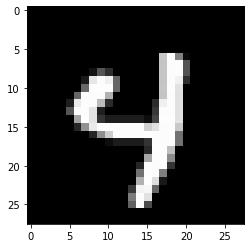

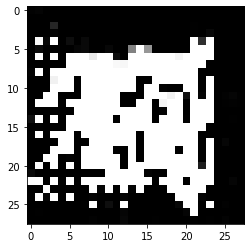

'epoch:  1501 ' [discriminator loss:  0.02641673  and acc:  0.9980469 ] [generator loss:  100.812584  and acc:  0.0 ]
'epoch:  1502 ' [discriminator loss:  1.7294865  and acc:  0.88671875 ] [generator loss:  136.6489  and acc:  0.0 ]
'epoch:  1503 ' [discriminator loss:  0.0075798826  and acc:  0.99609375 ] [generator loss:  74.46925  and acc:  0.0078125 ]
'epoch:  1504 ' [discriminator loss:  5.8509436  and acc:  0.7480469 ] [generator loss:  223.3015  and acc:  0.0 ]
'epoch:  1505 ' [discriminator loss:  4.0286317e-30  and acc:  1.0 ] [generator loss:  146.00131  and acc:  0.0 ]
'epoch:  1506 ' [discriminator loss:  0.09652584  and acc:  0.9941406 ] [generator loss:  86.927536  and acc:  0.00390625 ]
'epoch:  1507 ' [discriminator loss:  3.2385435  and acc:  0.8300781 ] [generator loss:  168.90244  and acc:  0.0 ]
'epoch:  1508 ' [discriminator loss:  2.3213477e-17  and acc:  1.0 ] [generator loss:  97.28433  and acc:  0.0 ]
'epoch:  1509 ' [discriminator loss:  1.8450536  and acc:  

'epoch:  1572 ' [discriminator loss:  3.608149e-12  and acc:  1.0 ] [generator loss:  141.4874  and acc:  0.0 ]
'epoch:  1573 ' [discriminator loss:  1.4388366  and acc:  0.93359375 ] [generator loss:  103.36456  and acc:  0.00390625 ]
'epoch:  1574 ' [discriminator loss:  7.1317406  and acc:  0.7636719 ] [generator loss:  204.80298  and acc:  0.0 ]
'epoch:  1575 ' [discriminator loss:  0.025745045  and acc:  0.9941406 ] [generator loss:  107.71708  and acc:  0.0 ]
'epoch:  1576 ' [discriminator loss:  4.488209  and acc:  0.8300781 ] [generator loss:  169.73874  and acc:  0.0 ]
'epoch:  1577 ' [discriminator loss:  0.52579623  and acc:  0.9609375 ] [generator loss:  110.315414  and acc:  0.0 ]
'epoch:  1578 ' [discriminator loss:  5.5860586  and acc:  0.8105469 ] [generator loss:  197.22629  and acc:  0.0 ]
'epoch:  1579 ' [discriminator loss:  0.16585638  and acc:  0.9941406 ] [generator loss:  106.52968  and acc:  0.00390625 ]
'epoch:  1580 ' [discriminator loss:  6.3871956  and acc:

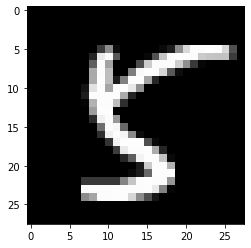

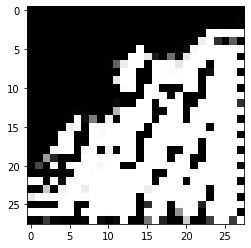

'epoch:  1601 ' [discriminator loss:  0.9161924  and acc:  0.95703125 ] [generator loss:  129.58337  and acc:  0.0078125 ]
'epoch:  1602 ' [discriminator loss:  3.6139307  and acc:  0.8691406 ] [generator loss:  238.86035  and acc:  0.0 ]
'epoch:  1603 ' [discriminator loss:  4.1925263e-13  and acc:  1.0 ] [generator loss:  143.27269  and acc:  0.0 ]
'epoch:  1604 ' [discriminator loss:  1.9325414  and acc:  0.90625 ] [generator loss:  211.48544  and acc:  0.0 ]
'epoch:  1605 ' [discriminator loss:  0.023761678  and acc:  0.9941406 ] [generator loss:  121.308105  and acc:  0.01953125 ]
'epoch:  1606 ' [discriminator loss:  4.7385955  and acc:  0.8261719 ] [generator loss:  325.86047  and acc:  0.0 ]
'epoch:  1607 ' [discriminator loss:  2.7442977e-20  and acc:  1.0 ] [generator loss:  211.58096  and acc:  0.0 ]
'epoch:  1608 ' [discriminator loss:  0.06712177  and acc:  0.99609375 ] [generator loss:  133.48366  and acc:  0.0 ]
'epoch:  1609 ' [discriminator loss:  3.6193013  and acc:  

'epoch:  1672 ' [discriminator loss:  7.4471617  and acc:  0.7949219 ] [generator loss:  289.74973  and acc:  0.0 ]
'epoch:  1673 ' [discriminator loss:  5.859532e-14  and acc:  1.0 ] [generator loss:  196.41603  and acc:  0.0 ]
'epoch:  1674 ' [discriminator loss:  0.17632586  and acc:  0.9785156 ] [generator loss:  118.51381  and acc:  0.01171875 ]
'epoch:  1675 ' [discriminator loss:  10.280565  and acc:  0.71875 ] [generator loss:  374.79916  and acc:  0.0 ]
'epoch:  1676 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  272.273  and acc:  0.0 ]
'epoch:  1677 ' [discriminator loss:  0.010371471  and acc:  0.9980469 ] [generator loss:  182.35452  and acc:  0.0 ]
'epoch:  1678 ' [discriminator loss:  1.226068  and acc:  0.9453125 ] [generator loss:  175.07504  and acc:  0.0 ]
'epoch:  1679 ' [discriminator loss:  1.0565827  and acc:  0.94921875 ] [generator loss:  159.82031  and acc:  0.0 ]
'epoch:  1680 ' [discriminator loss:  1.2427971  and acc:  0.9433594 ] [generator

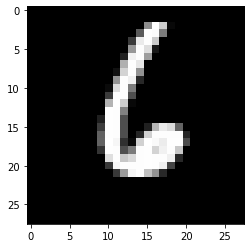

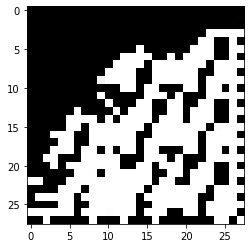

'epoch:  1701 ' [discriminator loss:  0.006221006  and acc:  0.9980469 ] [generator loss:  108.92383  and acc:  0.0 ]
'epoch:  1702 ' [discriminator loss:  4.703965  and acc:  0.80859375 ] [generator loss:  263.9621  and acc:  0.0 ]
'epoch:  1703 ' [discriminator loss:  2.5962377e-32  and acc:  1.0 ] [generator loss:  189.99338  and acc:  0.0 ]
'epoch:  1704 ' [discriminator loss:  0.105474934  and acc:  0.9902344 ] [generator loss:  117.82782  and acc:  0.01171875 ]
'epoch:  1705 ' [discriminator loss:  5.471916  and acc:  0.8066406 ] [generator loss:  254.5635  and acc:  0.0 ]
'epoch:  1706 ' [discriminator loss:  0.02748862  and acc:  0.9980469 ] [generator loss:  148.23938  and acc:  0.0 ]
'epoch:  1707 ' [discriminator loss:  3.857698  and acc:  0.84765625 ] [generator loss:  295.5873  and acc:  0.0 ]
'epoch:  1708 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  208.07642  and acc:  0.0 ]
'epoch:  1709 ' [discriminator loss:  0.012467001  and acc:  0.9980469 ] [gene

'epoch:  1772 ' [discriminator loss:  6.25465e-08  and acc:  1.0 ] [generator loss:  108.15778  and acc:  0.0 ]
'epoch:  1773 ' [discriminator loss:  1.0691738  and acc:  0.921875 ] [generator loss:  123.97174  and acc:  0.0 ]
'epoch:  1774 ' [discriminator loss:  0.32628804  and acc:  0.9765625 ] [generator loss:  76.51563  and acc:  0.01171875 ]
'epoch:  1775 ' [discriminator loss:  3.339786  and acc:  0.8046875 ] [generator loss:  216.25949  and acc:  0.0 ]
'epoch:  1776 ' [discriminator loss:  4.8070292e-24  and acc:  1.0 ] [generator loss:  150.75037  and acc:  0.0 ]
'epoch:  1777 ' [discriminator loss:  0.027486408  and acc:  0.9921875 ] [generator loss:  93.694016  and acc:  0.0 ]
'epoch:  1778 ' [discriminator loss:  2.012541  and acc:  0.87109375 ] [generator loss:  159.22455  and acc:  0.0 ]
'epoch:  1779 ' [discriminator loss:  0.002466142  and acc:  0.9980469 ] [generator loss:  95.753006  and acc:  0.0 ]
'epoch:  1780 ' [discriminator loss:  1.4599025  and acc:  0.8984375 

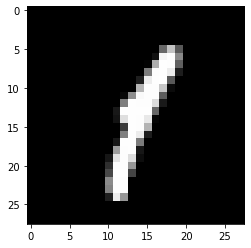

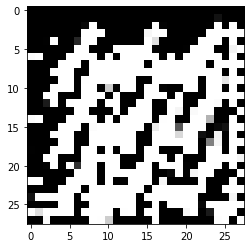

'epoch:  1801 ' [discriminator loss:  19.355204  and acc:  0.53515625 ] [generator loss:  156.32964  and acc:  0.0 ]
'epoch:  1802 ' [discriminator loss:  0.32529688  and acc:  0.97265625 ] [generator loss:  69.286194  and acc:  0.0234375 ]
'epoch:  1803 ' [discriminator loss:  19.471416  and acc:  0.5996094 ] [generator loss:  145.11067  and acc:  0.0 ]
'epoch:  1804 ' [discriminator loss:  2.4174278  and acc:  0.8847656 ] [generator loss:  79.86579  and acc:  0.04296875 ]
'epoch:  1805 ' [discriminator loss:  23.742992  and acc:  0.5683594 ] [generator loss:  187.00148  and acc:  0.0 ]
'epoch:  1806 ' [discriminator loss:  1.3623214  and acc:  0.91796875 ] [generator loss:  89.642166  and acc:  0.015625 ]
'epoch:  1807 ' [discriminator loss:  27.04412  and acc:  0.5683594 ] [generator loss:  221.48245  and acc:  0.0 ]
'epoch:  1808 ' [discriminator loss:  1.379822  and acc:  0.9472656 ] [generator loss:  92.114  and acc:  0.0625 ]
'epoch:  1809 ' [discriminator loss:  23.488194  and 

'epoch:  1870 ' [discriminator loss:  8.447569  and acc:  0.8339844 ] [generator loss:  433.95734  and acc:  0.0 ]
'epoch:  1871 ' [discriminator loss:  0.008952646  and acc:  0.9980469 ] [generator loss:  284.87085  and acc:  0.00390625 ]
'epoch:  1872 ' [discriminator loss:  1.319988  and acc:  0.96484375 ] [generator loss:  228.03735  and acc:  0.00390625 ]
'epoch:  1873 ' [discriminator loss:  3.2143872  and acc:  0.921875 ] [generator loss:  268.72937  and acc:  0.0 ]
'epoch:  1874 ' [discriminator loss:  0.55987984  and acc:  0.9707031 ] [generator loss:  209.8723  and acc:  0.01171875 ]
'epoch:  1875 ' [discriminator loss:  4.947193  and acc:  0.8847656 ] [generator loss:  373.55084  and acc:  0.0 ]
'epoch:  1876 ' [discriminator loss:  0.032081414  and acc:  0.9980469 ] [generator loss:  230.9873  and acc:  0.00390625 ]
'epoch:  1877 ' [discriminator loss:  2.2112288  and acc:  0.9472656 ] [generator loss:  247.87372  and acc:  0.0078125 ]
'epoch:  1878 ' [discriminator loss:  

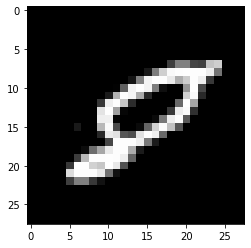

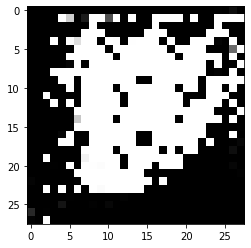

'epoch:  1901 ' [discriminator loss:  0.30041593  and acc:  0.98828125 ] [generator loss:  227.82869  and acc:  0.015625 ]
'epoch:  1902 ' [discriminator loss:  3.6501963  and acc:  0.9140625 ] [generator loss:  414.43723  and acc:  0.0 ]
'epoch:  1903 ' [discriminator loss:  6.851052e-12  and acc:  1.0 ] [generator loss:  268.73227  and acc:  0.0 ]
'epoch:  1904 ' [discriminator loss:  1.5471083  and acc:  0.9550781 ] [generator loss:  317.7803  and acc:  0.0 ]
'epoch:  1905 ' [discriminator loss:  0.35877824  and acc:  0.98828125 ] [generator loss:  229.78442  and acc:  0.0 ]
'epoch:  1906 ' [discriminator loss:  3.7803102  and acc:  0.9316406 ] [generator loss:  377.1466  and acc:  0.0 ]
'epoch:  1907 ' [discriminator loss:  0.15742233  and acc:  0.9941406 ] [generator loss:  270.91394  and acc:  0.0 ]
'epoch:  1908 ' [discriminator loss:  2.3109765  and acc:  0.9472656 ] [generator loss:  360.10596  and acc:  0.0 ]
'epoch:  1909 ' [discriminator loss:  0.05182457  and acc:  0.99609

'epoch:  1972 ' [discriminator loss:  6.2736866e-08  and acc:  1.0 ] [generator loss:  327.4878  and acc:  0.0 ]
'epoch:  1973 ' [discriminator loss:  0.7786684  and acc:  0.9707031 ] [generator loss:  280.73743  and acc:  0.00390625 ]
'epoch:  1974 ' [discriminator loss:  5.7830048  and acc:  0.8886719 ] [generator loss:  502.29883  and acc:  0.0 ]
'epoch:  1975 ' [discriminator loss:  2.693607e-16  and acc:  1.0 ] [generator loss:  363.71912  and acc:  0.0 ]
'epoch:  1976 ' [discriminator loss:  1.1743793  and acc:  0.96875 ] [generator loss:  310.80417  and acc:  0.0 ]
'epoch:  1977 ' [discriminator loss:  3.754395  and acc:  0.9160156 ] [generator loss:  453.28326  and acc:  0.0 ]
'epoch:  1978 ' [discriminator loss:  0.17104758  and acc:  0.99609375 ] [generator loss:  327.07928  and acc:  0.0 ]
'epoch:  1979 ' [discriminator loss:  2.7606175  and acc:  0.9394531 ] [generator loss:  397.85077  and acc:  0.00390625 ]
'epoch:  1980 ' [discriminator loss:  0.44502407  and acc:  0.988

In [28]:
noise_dim = 1
epoch_num = 2000
batch_size = 256
X_train, X_test, Y_train, Y_test = load_data()

d_loss_tracker = []
g_loss_tracker = []
d_acc_tracker = []
g_acc_tracker = []

for epoch in range(epoch_num):
    noise_input = np.random.uniform(-1, 1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise_input)

    for discriminator_epochs in range(1):
        genuine_images = X_train[np.random.randint(
            0, X_train.shape[0], size = batch_size), :, :, :]
        
        X_input = np.concatenate((genuine_images, fake_images))
        Y_label = np.ones([2 * batch_size, 1])
        Y_label[batch_size : , : ] = 0 

        d_loss = discriminator_compilation.train_on_batch(X_input, Y_label)
    
    Y_label = np.ones([batch_size, 1])
    g_loss = generator_compilation.train_on_batch(noise_input, Y_label)
    print("\'epoch: ", epoch,"\' [discriminator loss: ", d_loss[0], " and acc: ", d_loss[1],"] [generator loss: ",
          g_loss[0]," and acc: ", g_loss[1],"]")

    d_loss_tracker.append(d_loss[0])
    g_loss_tracker.append(g_loss[0])
    d_acc_tracker.append(d_loss[1])
    g_acc_tracker.append(g_loss[1])
    
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(genuine_images[0, :, :, 0], cmap='gray')
        plt.show()
        plt.imshow(fake_images[0, :, :, 0], cmap='gray')
        plt.show()

'epoch:  0 ' [discriminator loss:  3.8106015  and acc:  0.9296875 ] [generator loss:  510.0178  and acc:  0.0 ]


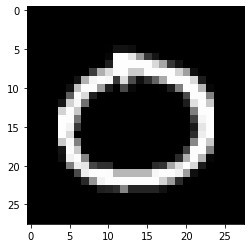

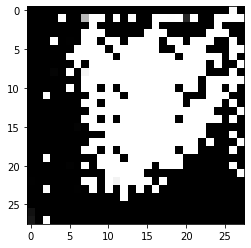

'epoch:  1 ' [discriminator loss:  0.06200979  and acc:  0.9980469 ] [generator loss:  382.88196  and acc:  0.0 ]
'epoch:  2 ' [discriminator loss:  0.46034682  and acc:  0.9785156 ] [generator loss:  348.31006  and acc:  0.00390625 ]
'epoch:  3 ' [discriminator loss:  0.8949631  and acc:  0.9667969 ] [generator loss:  383.46683  and acc:  0.0 ]
'epoch:  4 ' [discriminator loss:  0.46150228  and acc:  0.9824219 ] [generator loss:  349.52405  and acc:  0.0 ]
'epoch:  5 ' [discriminator loss:  1.6469814  and acc:  0.96484375 ] [generator loss:  420.11163  and acc:  0.0 ]
'epoch:  6 ' [discriminator loss:  0.29515514  and acc:  0.9902344 ] [generator loss:  309.52502  and acc:  0.0 ]
'epoch:  7 ' [discriminator loss:  2.1072288  and acc:  0.9550781 ] [generator loss:  461.6474  and acc:  0.0 ]
'epoch:  8 ' [discriminator loss:  0.015519572  and acc:  0.9980469 ] [generator loss:  315.9109  and acc:  0.0 ]
'epoch:  9 ' [discriminator loss:  2.0218792  and acc:  0.9550781 ] [generator loss:

'epoch:  74 ' [discriminator loss:  1.7284012e-32  and acc:  1.0 ] [generator loss:  352.17813  and acc:  0.0 ]
'epoch:  75 ' [discriminator loss:  1.428537  and acc:  0.9667969 ] [generator loss:  279.49182  and acc:  0.01171875 ]
'epoch:  76 ' [discriminator loss:  6.775049  and acc:  0.8652344 ] [generator loss:  523.861  and acc:  0.0 ]
'epoch:  77 ' [discriminator loss:  2.6613342e-25  and acc:  1.0 ] [generator loss:  345.01056  and acc:  0.0 ]
'epoch:  78 ' [discriminator loss:  0.7675544  and acc:  0.9707031 ] [generator loss:  252.16165  and acc:  0.015625 ]
'epoch:  79 ' [discriminator loss:  10.46983  and acc:  0.84765625 ] [generator loss:  503.93735  and acc:  0.0 ]
'epoch:  80 ' [discriminator loss:  0.051668007  and acc:  0.99609375 ] [generator loss:  346.47998  and acc:  0.0 ]
'epoch:  81 ' [discriminator loss:  2.3675747  and acc:  0.94921875 ] [generator loss:  334.31775  and acc:  0.0 ]
'epoch:  82 ' [discriminator loss:  3.6037884  and acc:  0.9433594 ] [generator 

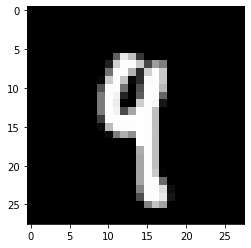

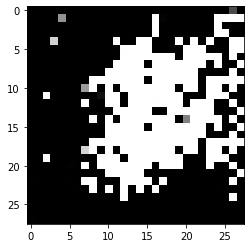

'epoch:  101 ' [discriminator loss:  4.6945906  and acc:  0.9316406 ] [generator loss:  566.02075  and acc:  0.0 ]
'epoch:  102 ' [discriminator loss:  0.30302826  and acc:  0.9941406 ] [generator loss:  401.23016  and acc:  0.0078125 ]
'epoch:  103 ' [discriminator loss:  4.065357  and acc:  0.9375 ] [generator loss:  588.5303  and acc:  0.0 ]
'epoch:  104 ' [discriminator loss:  0.2353352  and acc:  0.99609375 ] [generator loss:  402.13007  and acc:  0.00390625 ]
'epoch:  105 ' [discriminator loss:  5.64326  and acc:  0.93359375 ] [generator loss:  621.72687  and acc:  0.0 ]
'epoch:  106 ' [discriminator loss:  0.24786592  and acc:  0.9980469 ] [generator loss:  431.1223  and acc:  0.00390625 ]
'epoch:  107 ' [discriminator loss:  2.5224366  and acc:  0.9628906 ] [generator loss:  495.80707  and acc:  0.0 ]
'epoch:  108 ' [discriminator loss:  1.9359515  and acc:  0.97265625 ] [generator loss:  456.51895  and acc:  0.0078125 ]
'epoch:  109 ' [discriminator loss:  1.0422319  and acc: 

'epoch:  174 ' [discriminator loss:  4.609186  and acc:  0.9433594 ] [generator loss:  787.84717  and acc:  0.0 ]
'epoch:  175 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  634.083  and acc:  0.0 ]
'epoch:  176 ' [discriminator loss:  2.4192364e-15  and acc:  1.0 ] [generator loss:  443.50983  and acc:  0.0 ]
'epoch:  177 ' [discriminator loss:  1.0889274  and acc:  0.9785156 ] [generator loss:  476.03464  and acc:  0.0 ]
'epoch:  178 ' [discriminator loss:  0.5665858  and acc:  0.984375 ] [generator loss:  428.22827  and acc:  0.0 ]
'epoch:  179 ' [discriminator loss:  1.2692764  and acc:  0.98046875 ] [generator loss:  420.65198  and acc:  0.0 ]
'epoch:  180 ' [discriminator loss:  0.9747923  and acc:  0.98828125 ] [generator loss:  370.28784  and acc:  0.0 ]
'epoch:  181 ' [discriminator loss:  2.8033724  and acc:  0.94140625 ] [generator loss:  688.7613  and acc:  0.0 ]
'epoch:  182 ' [discriminator loss:  1.778272e-15  and acc:  1.0 ] [generator loss:  524.8695  a

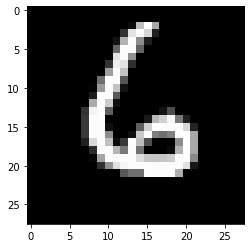

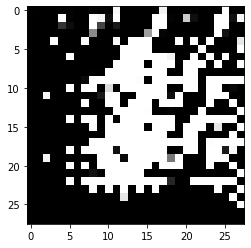

'epoch:  201 ' [discriminator loss:  0.3154901  and acc:  0.9941406 ] [generator loss:  314.21677  and acc:  0.0 ]
'epoch:  202 ' [discriminator loss:  24.137184  and acc:  0.7480469 ] [generator loss:  674.8116  and acc:  0.0 ]
'epoch:  203 ' [discriminator loss:  6.1698915e-07  and acc:  1.0 ] [generator loss:  394.78564  and acc:  0.0 ]
'epoch:  204 ' [discriminator loss:  13.612965  and acc:  0.8183594 ] [generator loss:  571.9702  and acc:  0.0 ]
'epoch:  205 ' [discriminator loss:  0.6966084  and acc:  0.984375 ] [generator loss:  268.60193  and acc:  0.01953125 ]
'epoch:  206 ' [discriminator loss:  100.680954  and acc:  0.5371094 ] [generator loss:  1058.4163  and acc:  0.0 ]
'epoch:  207 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  670.1736  and acc:  0.0 ]
'epoch:  208 ' [discriminator loss:  4.766125e-17  and acc:  1.0 ] [generator loss:  367.26065  and acc:  0.0078125 ]
'epoch:  209 ' [discriminator loss:  11.571489  and acc:  0.8378906 ] [generator loss: 

'epoch:  273 ' [discriminator loss:  4.5393114  and acc:  0.92578125 ] [generator loss:  503.79822  and acc:  0.0 ]
'epoch:  274 ' [discriminator loss:  0.21646744  and acc:  0.99609375 ] [generator loss:  267.68124  and acc:  0.015625 ]
'epoch:  275 ' [discriminator loss:  20.819345  and acc:  0.76953125 ] [generator loss:  1016.71204  and acc:  0.0 ]
'epoch:  276 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  737.0711  and acc:  0.0 ]
'epoch:  277 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  437.38892  and acc:  0.0 ]
'epoch:  278 ' [discriminator loss:  13.920086  and acc:  0.83203125 ] [generator loss:  1005.32965  and acc:  0.0 ]
'epoch:  279 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  731.1299  and acc:  0.0 ]
'epoch:  280 ' [discriminator loss:  2.3377184e-07  and acc:  1.0 ] [generator loss:  451.37457  and acc:  0.00390625 ]
'epoch:  281 ' [discriminator loss:  9.759625  and acc:  0.8828125 ] [generator loss:  762.86255  and

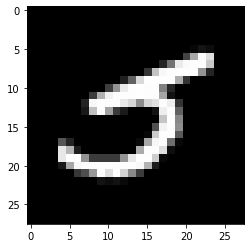

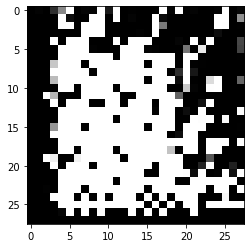

'epoch:  301 ' [discriminator loss:  13.882004  and acc:  0.81640625 ] [generator loss:  961.8098  and acc:  0.0 ]
'epoch:  302 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  706.66296  and acc:  0.0 ]
'epoch:  303 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  441.8391  and acc:  0.0 ]
'epoch:  304 ' [discriminator loss:  6.3109326  and acc:  0.9003906 ] [generator loss:  821.07666  and acc:  0.0 ]
'epoch:  305 ' [discriminator loss:  5.592644e-32  and acc:  1.0 ] [generator loss:  610.21655  and acc:  0.0 ]
'epoch:  306 ' [discriminator loss:  0.086685166  and acc:  0.9941406 ] [generator loss:  398.7617  and acc:  0.0078125 ]
'epoch:  307 ' [discriminator loss:  4.815769  and acc:  0.92578125 ] [generator loss:  597.2103  and acc:  0.0 ]
'epoch:  308 ' [discriminator loss:  2.3817517e-27  and acc:  1.0 ] [generator loss:  398.62766  and acc:  0.0 ]
'epoch:  309 ' [discriminator loss:  3.342827  and acc:  0.953125 ] [generator loss:  448.3877  and acc:

'epoch:  374 ' [discriminator loss:  0.09849473  and acc:  0.9980469 ] [generator loss:  379.39963  and acc:  0.0 ]
'epoch:  375 ' [discriminator loss:  5.175026  and acc:  0.92578125 ] [generator loss:  690.8834  and acc:  0.0 ]
'epoch:  376 ' [discriminator loss:  1.0486438e-22  and acc:  1.0 ] [generator loss:  477.0644  and acc:  0.0 ]
'epoch:  377 ' [discriminator loss:  1.5731189  and acc:  0.9765625 ] [generator loss:  430.65668  and acc:  0.00390625 ]
'epoch:  378 ' [discriminator loss:  3.3166442  and acc:  0.94921875 ] [generator loss:  601.3018  and acc:  0.0 ]
'epoch:  379 ' [discriminator loss:  0.07766698  and acc:  0.9980469 ] [generator loss:  383.1784  and acc:  0.00390625 ]
'epoch:  380 ' [discriminator loss:  3.8225536  and acc:  0.9316406 ] [generator loss:  706.2086  and acc:  0.0 ]
'epoch:  381 ' [discriminator loss:  1.05489645e-11  and acc:  1.0 ] [generator loss:  487.25577  and acc:  0.00390625 ]
'epoch:  382 ' [discriminator loss:  1.4348923  and acc:  0.9746

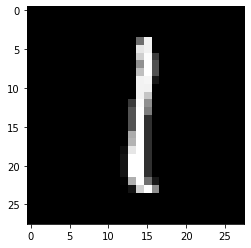

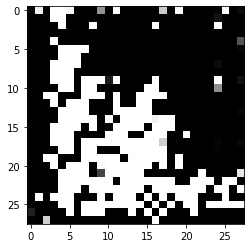

'epoch:  401 ' [discriminator loss:  0.000547071  and acc:  1.0 ] [generator loss:  420.12305  and acc:  0.0 ]
'epoch:  402 ' [discriminator loss:  2.973119  and acc:  0.9589844 ] [generator loss:  571.5067  and acc:  0.0 ]
'epoch:  403 ' [discriminator loss:  0.16250908  and acc:  0.9941406 ] [generator loss:  410.83954  and acc:  0.0 ]
'epoch:  404 ' [discriminator loss:  4.0114403  and acc:  0.9472656 ] [generator loss:  691.16003  and acc:  0.0 ]
'epoch:  405 ' [discriminator loss:  2.329007e-23  and acc:  1.0 ] [generator loss:  478.64453  and acc:  0.00390625 ]
'epoch:  406 ' [discriminator loss:  1.2726038  and acc:  0.9824219 ] [generator loss:  473.42444  and acc:  0.0 ]
'epoch:  407 ' [discriminator loss:  1.8703145  and acc:  0.9609375 ] [generator loss:  607.6643  and acc:  0.0 ]
'epoch:  408 ' [discriminator loss:  0.029963607  and acc:  0.9980469 ] [generator loss:  419.907  and acc:  0.01171875 ]
'epoch:  409 ' [discriminator loss:  2.337322  and acc:  0.9550781 ] [gener

'epoch:  474 ' [discriminator loss:  0.321801  and acc:  0.9921875 ] [generator loss:  444.27606  and acc:  0.0078125 ]
'epoch:  475 ' [discriminator loss:  25.40884  and acc:  0.8066406 ] [generator loss:  1173.251  and acc:  0.0 ]
'epoch:  476 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  816.02545  and acc:  0.0 ]
'epoch:  477 ' [discriminator loss:  0.0046638385  and acc:  0.9980469 ] [generator loss:  454.25052  and acc:  0.01953125 ]
'epoch:  478 ' [discriminator loss:  27.303806  and acc:  0.7792969 ] [generator loss:  1271.8778  and acc:  0.0 ]
'epoch:  479 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  891.54407  and acc:  0.0 ]
'epoch:  480 ' [discriminator loss:  0.44713357  and acc:  0.9902344 ] [generator loss:  530.48956  and acc:  0.0078125 ]
'epoch:  481 ' [discriminator loss:  36.26566  and acc:  0.7910156 ] [generator loss:  1369.7139  and acc:  0.0 ]
'epoch:  482 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  955.4157 

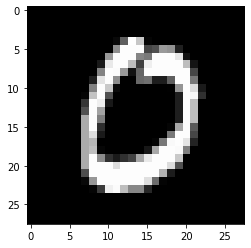

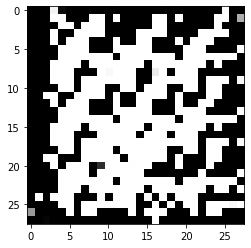

'epoch:  501 ' [discriminator loss:  1.5419501  and acc:  0.9824219 ] [generator loss:  530.133  and acc:  0.00390625 ]
'epoch:  502 ' [discriminator loss:  16.231197  and acc:  0.8496094 ] [generator loss:  1394.9657  and acc:  0.0 ]
'epoch:  503 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1025.9331  and acc:  0.0 ]
'epoch:  504 ' [discriminator loss:  0.0003689648  and acc:  1.0 ] [generator loss:  672.9512  and acc:  0.0 ]
'epoch:  505 ' [discriminator loss:  9.528089  and acc:  0.9121094 ] [generator loss:  1078.4227  and acc:  0.0 ]
'epoch:  506 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  735.8181  and acc:  0.0 ]
'epoch:  507 ' [discriminator loss:  1.4565728  and acc:  0.9824219 ] [generator loss:  510.55154  and acc:  0.01171875 ]
'epoch:  508 ' [discriminator loss:  15.452396  and acc:  0.8652344 ] [generator loss:  1314.3906  and acc:  0.0 ]
'epoch:  509 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  959.3185  and acc:  0.

'epoch:  574 ' [discriminator loss:  6.8902245  and acc:  0.91796875 ] [generator loss:  802.68933  and acc:  0.0 ]
'epoch:  575 ' [discriminator loss:  0.23817572  and acc:  0.9941406 ] [generator loss:  565.2937  and acc:  0.0 ]
'epoch:  576 ' [discriminator loss:  10.308341  and acc:  0.8964844 ] [generator loss:  856.4757  and acc:  0.0 ]
'epoch:  577 ' [discriminator loss:  7.211321e-06  and acc:  1.0 ] [generator loss:  531.6108  and acc:  0.00390625 ]
'epoch:  578 ' [discriminator loss:  9.382511  and acc:  0.90625 ] [generator loss:  850.72107  and acc:  0.0 ]
'epoch:  579 ' [discriminator loss:  0.18680587  and acc:  0.9941406 ] [generator loss:  503.7616  and acc:  0.00390625 ]
'epoch:  580 ' [discriminator loss:  19.96205  and acc:  0.8515625 ] [generator loss:  1182.5577  and acc:  0.0 ]
'epoch:  581 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  820.61426  and acc:  0.0 ]
'epoch:  582 ' [discriminator loss:  0.15002853  and acc:  0.9941406 ] [generator loss

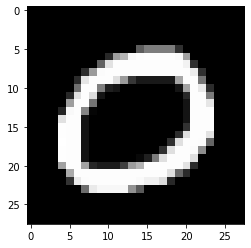

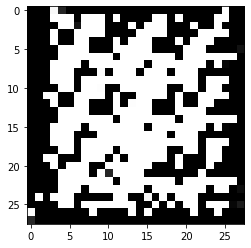

'epoch:  601 ' [discriminator loss:  21.915472  and acc:  0.8144531 ] [generator loss:  1480.754  and acc:  0.0 ]
'epoch:  602 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1106.1724  and acc:  0.0 ]
'epoch:  603 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  799.6436  and acc:  0.0 ]
'epoch:  604 ' [discriminator loss:  0.0013242263  and acc:  1.0 ] [generator loss:  496.66656  and acc:  0.00390625 ]
'epoch:  605 ' [discriminator loss:  13.007671  and acc:  0.8886719 ] [generator loss:  1013.35657  and acc:  0.0 ]
'epoch:  606 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  753.58026  and acc:  0.0 ]
'epoch:  607 ' [discriminator loss:  0.4850307  and acc:  0.99609375 ] [generator loss:  459.26068  and acc:  0.0078125 ]
'epoch:  608 ' [discriminator loss:  8.664913  and acc:  0.9003906 ] [generator loss:  901.1763  and acc:  0.0 ]
'epoch:  609 ' [discriminator loss:  7.604679e-18  and acc:  1.0 ] [generator loss:  604.6656  and acc:  0.0

'epoch:  674 ' [discriminator loss:  7.6925917  and acc:  0.9082031 ] [generator loss:  1071.8992  and acc:  0.0 ]
'epoch:  675 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  739.5876  and acc:  0.0 ]
'epoch:  676 ' [discriminator loss:  0.6685926  and acc:  0.9902344 ] [generator loss:  511.38388  and acc:  0.0 ]
'epoch:  677 ' [discriminator loss:  8.195121  and acc:  0.91015625 ] [generator loss:  972.76587  and acc:  0.0 ]
'epoch:  678 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  613.1809  and acc:  0.0 ]
'epoch:  679 ' [discriminator loss:  2.0069623  and acc:  0.97265625 ] [generator loss:  543.6074  and acc:  0.0078125 ]
'epoch:  680 ' [discriminator loss:  2.7329314  and acc:  0.9609375 ] [generator loss:  619.49225  and acc:  0.00390625 ]
'epoch:  681 ' [discriminator loss:  2.9400752  and acc:  0.96875 ] [generator loss:  595.1637  and acc:  0.00390625 ]
'epoch:  682 ' [discriminator loss:  1.9846249  and acc:  0.9746094 ] [generator loss:  5

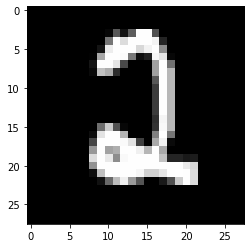

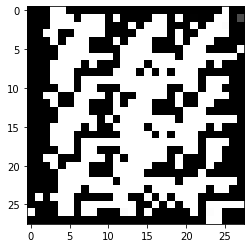

'epoch:  701 ' [discriminator loss:  41.5376  and acc:  0.7734375 ] [generator loss:  1747.212  and acc:  0.0 ]
'epoch:  702 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1345.0023  and acc:  0.0 ]
'epoch:  703 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  989.4833  and acc:  0.0 ]
'epoch:  704 ' [discriminator loss:  3.4265672e-16  and acc:  1.0 ] [generator loss:  587.1825  and acc:  0.0078125 ]
'epoch:  705 ' [discriminator loss:  34.825226  and acc:  0.7890625 ] [generator loss:  1738.3308  and acc:  0.0 ]
'epoch:  706 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1379.5952  and acc:  0.0 ]
'epoch:  707 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1037.2053  and acc:  0.0 ]
'epoch:  708 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  725.5308  and acc:  0.00390625 ]
'epoch:  709 ' [discriminator loss:  2.1261377  and acc:  0.97265625 ] [generator loss:  607.7948  and acc:  0.0 ]
'epoch:  710 ' [disc

'epoch:  774 ' [discriminator loss:  6.325333e-30  and acc:  1.0 ] [generator loss:  480.12228  and acc:  0.015625 ]
'epoch:  775 ' [discriminator loss:  18.45426  and acc:  0.8339844 ] [generator loss:  1384.4736  and acc:  0.0 ]
'epoch:  776 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1046.2745  and acc:  0.0 ]
'epoch:  777 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  724.0154  and acc:  0.0 ]
'epoch:  778 ' [discriminator loss:  2.3577914  and acc:  0.9707031 ] [generator loss:  678.8277  and acc:  0.0 ]
'epoch:  779 ' [discriminator loss:  1.7183852  and acc:  0.9785156 ] [generator loss:  550.5671  and acc:  0.0 ]
'epoch:  780 ' [discriminator loss:  7.3645167  and acc:  0.9160156 ] [generator loss:  910.6807  and acc:  0.0 ]
'epoch:  781 ' [discriminator loss:  2.8862667e-26  and acc:  1.0 ] [generator loss:  630.0635  and acc:  0.0 ]
'epoch:  782 ' [discriminator loss:  0.9290991  and acc:  0.9863281 ] [generator loss:  446.3999  and acc:  0.

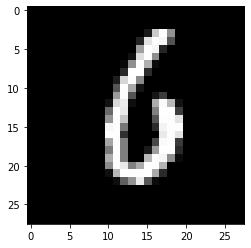

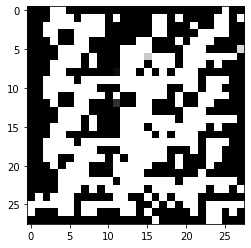

'epoch:  801 ' [discriminator loss:  0.37648314  and acc:  0.99609375 ] [generator loss:  432.89966  and acc:  0.0078125 ]
'epoch:  802 ' [discriminator loss:  11.566593  and acc:  0.8691406 ] [generator loss:  1054.1191  and acc:  0.0 ]
'epoch:  803 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  727.8834  and acc:  0.0 ]
'epoch:  804 ' [discriminator loss:  0.26111314  and acc:  0.9941406 ] [generator loss:  442.99585  and acc:  0.0078125 ]
'epoch:  805 ' [discriminator loss:  12.789532  and acc:  0.8769531 ] [generator loss:  1005.4772  and acc:  0.0 ]
'epoch:  806 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  681.66846  and acc:  0.0 ]
'epoch:  807 ' [discriminator loss:  1.5407293  and acc:  0.9765625 ] [generator loss:  552.16455  and acc:  0.00390625 ]
'epoch:  808 ' [discriminator loss:  10.923405  and acc:  0.90234375 ] [generator loss:  985.0135  and acc:  0.0 ]
'epoch:  809 ' [discriminator loss:  6.1377274e-32  and acc:  1.0 ] [generator loss

'epoch:  873 ' [discriminator loss:  4.946303  and acc:  0.9394531 ] [generator loss:  908.3871  and acc:  0.0 ]
'epoch:  874 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  600.3488  and acc:  0.0 ]
'epoch:  875 ' [discriminator loss:  3.202971  and acc:  0.953125 ] [generator loss:  888.9352  and acc:  0.0 ]
'epoch:  876 ' [discriminator loss:  8.9196296e-14  and acc:  1.0 ] [generator loss:  572.5216  and acc:  0.0 ]
'epoch:  877 ' [discriminator loss:  2.0567827  and acc:  0.96484375 ] [generator loss:  688.88184  and acc:  0.0 ]
'epoch:  878 ' [discriminator loss:  0.19686748  and acc:  0.9941406 ] [generator loss:  488.77042  and acc:  0.0 ]
'epoch:  879 ' [discriminator loss:  7.025115  and acc:  0.9140625 ] [generator loss:  1166.759  and acc:  0.0 ]
'epoch:  880 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  865.0987  and acc:  0.0 ]
'epoch:  881 ' [discriminator loss:  8.0677685e-13  and acc:  1.0 ] [generator loss:  520.3076  and acc:  0.007812

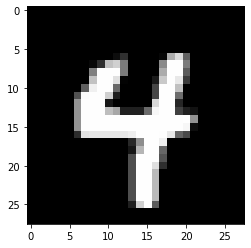

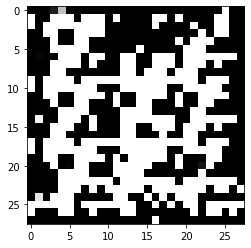

'epoch:  901 ' [discriminator loss:  0.15743142  and acc:  0.9980469 ] [generator loss:  475.35406  and acc:  0.015625 ]
'epoch:  902 ' [discriminator loss:  33.286484  and acc:  0.7734375 ] [generator loss:  1522.3063  and acc:  0.0 ]
'epoch:  903 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1101.9098  and acc:  0.0 ]
'epoch:  904 ' [discriminator loss:  2.7617903e-30  and acc:  1.0 ] [generator loss:  791.9647  and acc:  0.0 ]
'epoch:  905 ' [discriminator loss:  6.5911007  and acc:  0.94140625 ] [generator loss:  837.6511  and acc:  0.0 ]
'epoch:  906 ' [discriminator loss:  0.39382014  and acc:  0.9902344 ] [generator loss:  586.0801  and acc:  0.00390625 ]
'epoch:  907 ' [discriminator loss:  11.971536  and acc:  0.90625 ] [generator loss:  1002.4735  and acc:  0.0 ]
'epoch:  908 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  629.6847  and acc:  0.0078125 ]
'epoch:  909 ' [discriminator loss:  4.0309925  and acc:  0.9589844 ] [generator loss:  617

'epoch:  974 ' [discriminator loss:  0.016380426  and acc:  0.9980469 ] [generator loss:  645.4328  and acc:  0.0 ]
'epoch:  975 ' [discriminator loss:  1.2687329  and acc:  0.9785156 ] [generator loss:  556.54663  and acc:  0.015625 ]
'epoch:  976 ' [discriminator loss:  5.623086  and acc:  0.9453125 ] [generator loss:  958.81537  and acc:  0.0 ]
'epoch:  977 ' [discriminator loss:  0.188724  and acc:  0.99609375 ] [generator loss:  676.61926  and acc:  0.0 ]
'epoch:  978 ' [discriminator loss:  4.094999  and acc:  0.9609375 ] [generator loss:  840.19293  and acc:  0.0 ]
'epoch:  979 ' [discriminator loss:  7.815687e-34  and acc:  1.0 ] [generator loss:  529.7224  and acc:  0.00390625 ]
'epoch:  980 ' [discriminator loss:  11.2013  and acc:  0.91015625 ] [generator loss:  1291.3102  and acc:  0.0 ]
'epoch:  981 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1019.056  and acc:  0.0 ]
'epoch:  982 ' [discriminator loss:  3.8471087e-05  and acc:  1.0 ] [generator loss:  6

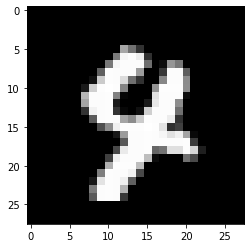

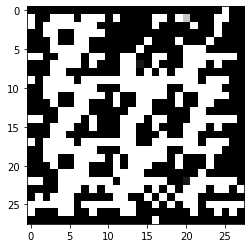

'epoch:  1001 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  937.1482  and acc:  0.0 ]
'epoch:  1002 ' [discriminator loss:  0.26125163  and acc:  0.99609375 ] [generator loss:  646.00916  and acc:  0.00390625 ]
'epoch:  1003 ' [discriminator loss:  11.284733  and acc:  0.9082031 ] [generator loss:  1059.9309  and acc:  0.0 ]
'epoch:  1004 ' [discriminator loss:  0.38366985  and acc:  0.99609375 ] [generator loss:  766.0514  and acc:  0.00390625 ]
'epoch:  1005 ' [discriminator loss:  2.7838614  and acc:  0.9765625 ] [generator loss:  589.984  and acc:  0.01171875 ]
'epoch:  1006 ' [discriminator loss:  16.0631  and acc:  0.875 ] [generator loss:  1268.7456  and acc:  0.0 ]
'epoch:  1007 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  856.7876  and acc:  0.0 ]
'epoch:  1008 ' [discriminator loss:  0.19741523  and acc:  0.99609375 ] [generator loss:  509.92377  and acc:  0.01953125 ]
'epoch:  1009 ' [discriminator loss:  26.41399  and acc:  0.828125 ] [gen

'epoch:  1073 ' [discriminator loss:  6.832505  and acc:  0.94921875 ] [generator loss:  1141.9282  and acc:  0.0 ]
'epoch:  1074 ' [discriminator loss:  0.1719964  and acc:  0.9980469 ] [generator loss:  856.078  and acc:  0.00390625 ]
'epoch:  1075 ' [discriminator loss:  4.5759177  and acc:  0.9589844 ] [generator loss:  1211.2717  and acc:  0.0 ]
'epoch:  1076 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  907.1598  and acc:  0.0 ]
'epoch:  1077 ' [discriminator loss:  0.4219013  and acc:  0.99609375 ] [generator loss:  662.1232  and acc:  0.00390625 ]
'epoch:  1078 ' [discriminator loss:  12.274588  and acc:  0.91015625 ] [generator loss:  1600.8889  and acc:  0.0 ]
'epoch:  1079 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1238.1975  and acc:  0.0 ]
'epoch:  1080 ' [discriminator loss:  10.271681  and acc:  0.99609375 ] [generator loss:  642.14465  and acc:  0.0078125 ]
'epoch:  1081 ' [discriminator loss:  9.123465  and acc:  0.9140625 ] [genera

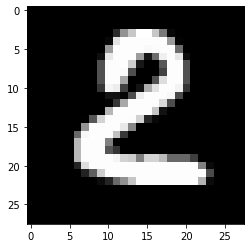

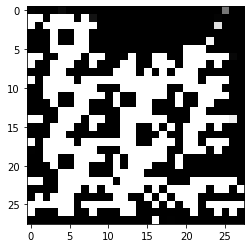

'epoch:  1101 ' [discriminator loss:  1.2695872  and acc:  0.9824219 ] [generator loss:  717.6823  and acc:  0.0078125 ]
'epoch:  1102 ' [discriminator loss:  13.189902  and acc:  0.9082031 ] [generator loss:  1309.3717  and acc:  0.0 ]
'epoch:  1103 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  978.9421  and acc:  0.0 ]
'epoch:  1104 ' [discriminator loss:  1.7386019  and acc:  0.98828125 ] [generator loss:  733.36633  and acc:  0.01171875 ]
'epoch:  1105 ' [discriminator loss:  11.240393  and acc:  0.9160156 ] [generator loss:  1320.8691  and acc:  0.0 ]
'epoch:  1106 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  919.626  and acc:  0.0 ]
'epoch:  1107 ' [discriminator loss:  1.2746042  and acc:  0.984375 ] [generator loss:  700.9994  and acc:  0.0078125 ]
'epoch:  1108 ' [discriminator loss:  14.418716  and acc:  0.90625 ] [generator loss:  1457.7318  and acc:  0.0 ]
'epoch:  1109 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1038.32

'epoch:  1172 ' [discriminator loss:  5.2719587e-22  and acc:  1.0 ] [generator loss:  734.1971  and acc:  0.00390625 ]
'epoch:  1173 ' [discriminator loss:  8.5609665  and acc:  0.93359375 ] [generator loss:  1538.5396  and acc:  0.0 ]
'epoch:  1174 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1114.1256  and acc:  0.0 ]
'epoch:  1175 ' [discriminator loss:  0.63668585  and acc:  0.9941406 ] [generator loss:  844.99963  and acc:  0.00390625 ]
'epoch:  1176 ' [discriminator loss:  11.705896  and acc:  0.9042969 ] [generator loss:  1943.2716  and acc:  0.0 ]
'epoch:  1177 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1571.5647  and acc:  0.0 ]
'epoch:  1178 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1053.2123  and acc:  0.0 ]
'epoch:  1179 ' [discriminator loss:  4.075059  and acc:  0.9667969 ] [generator loss:  1426.8551  and acc:  0.0 ]
'epoch:  1180 ' [discriminator loss:  4.5095562e-35  and acc:  1.0 ] [generator loss:  1032.134 

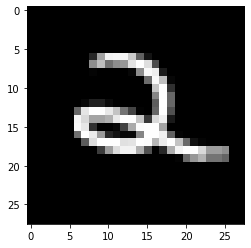

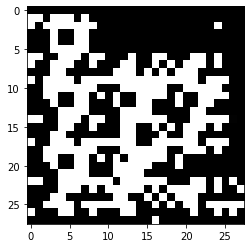

'epoch:  1201 ' [discriminator loss:  0.57834923  and acc:  0.9941406 ] [generator loss:  780.2506  and acc:  0.0 ]
'epoch:  1202 ' [discriminator loss:  2.0183573  and acc:  0.97265625 ] [generator loss:  1046.949  and acc:  0.0 ]
'epoch:  1203 ' [discriminator loss:  0.04218236  and acc:  0.9980469 ] [generator loss:  799.1703  and acc:  0.0 ]
'epoch:  1204 ' [discriminator loss:  3.35466  and acc:  0.96875 ] [generator loss:  1125.3544  and acc:  0.0 ]
'epoch:  1205 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  799.16144  and acc:  0.0 ]
'epoch:  1206 ' [discriminator loss:  2.6022582  and acc:  0.9628906 ] [generator loss:  1390.189  and acc:  0.0 ]
'epoch:  1207 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1016.90466  and acc:  0.0 ]
'epoch:  1208 ' [discriminator loss:  0.20317045  and acc:  0.99609375 ] [generator loss:  772.35706  and acc:  0.0 ]
'epoch:  1209 ' [discriminator loss:  4.473978  and acc:  0.9609375 ] [generator loss:  1376.0759 

'epoch:  1274 ' [discriminator loss:  1.305321  and acc:  0.98828125 ] [generator loss:  1036.7184  and acc:  0.0 ]
'epoch:  1275 ' [discriminator loss:  5.029332  and acc:  0.97265625 ] [generator loss:  1292.6267  and acc:  0.0 ]
'epoch:  1276 ' [discriminator loss:  1.6635678e-27  and acc:  1.0 ] [generator loss:  907.71783  and acc:  0.01171875 ]
'epoch:  1277 ' [discriminator loss:  13.58479  and acc:  0.9238281 ] [generator loss:  2229.9485  and acc:  0.0 ]
'epoch:  1278 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1760.0737  and acc:  0.0 ]
'epoch:  1279 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1333.4221  and acc:  0.0 ]
'epoch:  1280 ' [discriminator loss:  1.3051018  and acc:  0.98828125 ] [generator loss:  1220.9192  and acc:  0.0 ]
'epoch:  1281 ' [discriminator loss:  2.6321878  and acc:  0.97265625 ] [generator loss:  1459.4314  and acc:  0.0 ]
'epoch:  1282 ' [discriminator loss:  4.8343785e-34  and acc:  1.0 ] [generator loss:  110

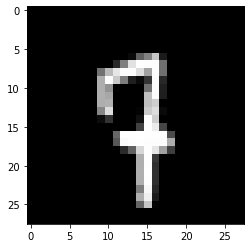

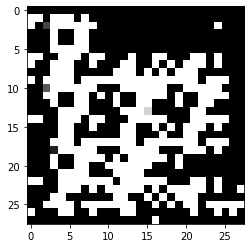

'epoch:  1301 ' [discriminator loss:  0.8799236  and acc:  0.9941406 ] [generator loss:  996.75195  and acc:  0.0 ]
'epoch:  1302 ' [discriminator loss:  7.605352  and acc:  0.9511719 ] [generator loss:  1767.7921  and acc:  0.0 ]
'epoch:  1303 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1399.9102  and acc:  0.0 ]
'epoch:  1304 ' [discriminator loss:  1.1684555  and acc:  0.9921875 ] [generator loss:  1116.1277  and acc:  0.0 ]
'epoch:  1305 ' [discriminator loss:  2.023181  and acc:  0.984375 ] [generator loss:  1058.8671  and acc:  0.0 ]
'epoch:  1306 ' [discriminator loss:  1.0252182  and acc:  0.98828125 ] [generator loss:  960.74524  and acc:  0.01171875 ]
'epoch:  1307 ' [discriminator loss:  5.245734  and acc:  0.9589844 ] [generator loss:  1569.3092  and acc:  0.0 ]
'epoch:  1308 ' [discriminator loss:  2.8677092e-05  and acc:  1.0 ] [generator loss:  1222.4493  and acc:  0.0 ]
'epoch:  1309 ' [discriminator loss:  1.1807843  and acc:  0.9902344 ] [generator 

'epoch:  1373 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1566.3904  and acc:  0.0 ]
'epoch:  1374 ' [discriminator loss:  0.6486539  and acc:  0.9921875 ] [generator loss:  975.6788  and acc:  0.01171875 ]
'epoch:  1375 ' [discriminator loss:  33.45158  and acc:  0.8535156 ] [generator loss:  1885.9203  and acc:  0.0 ]
'epoch:  1376 ' [discriminator loss:  0.0007874651  and acc:  1.0 ] [generator loss:  1266.8217  and acc:  0.0 ]
'epoch:  1377 ' [discriminator loss:  4.7977433  and acc:  0.9628906 ] [generator loss:  981.42816  and acc:  0.0234375 ]
'epoch:  1378 ' [discriminator loss:  27.368687  and acc:  0.8652344 ] [generator loss:  1610.0751  and acc:  0.0 ]
'epoch:  1379 ' [discriminator loss:  1.0050882  and acc:  0.9902344 ] [generator loss:  988.2457  and acc:  0.0078125 ]
'epoch:  1380 ' [discriminator loss:  27.778849  and acc:  0.8496094 ] [generator loss:  1713.4409  and acc:  0.0 ]
'epoch:  1381 ' [discriminator loss:  1.2719737  and acc:  0.9921875 ] 

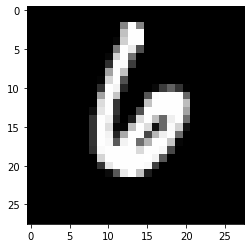

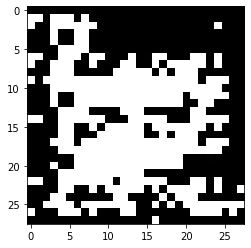

'epoch:  1401 ' [discriminator loss:  0.06016994  and acc:  0.9980469 ] [generator loss:  1557.3611  and acc:  0.0 ]
'epoch:  1402 ' [discriminator loss:  1.6415453  and acc:  0.9902344 ] [generator loss:  1021.9765  and acc:  0.0078125 ]
'epoch:  1403 ' [discriminator loss:  19.772636  and acc:  0.8964844 ] [generator loss:  2054.823  and acc:  0.0 ]
'epoch:  1404 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1494.1179  and acc:  0.0 ]
'epoch:  1405 ' [discriminator loss:  2.0383086  and acc:  0.98828125 ] [generator loss:  995.402  and acc:  0.015625 ]
'epoch:  1406 ' [discriminator loss:  25.716192  and acc:  0.8613281 ] [generator loss:  2542.2542  and acc:  0.0 ]
'epoch:  1407 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1846.6733  and acc:  0.0 ]
'epoch:  1408 ' [discriminator loss:  0.32127282  and acc:  0.9941406 ] [generator loss:  1288.4036  and acc:  0.0 ]
'epoch:  1409 ' [discriminator loss:  7.9928637  and acc:  0.9453125 ] [generator los

'epoch:  1473 ' [discriminator loss:  6.161927  and acc:  0.9511719 ] [generator loss:  1548.0989  and acc:  0.0 ]
'epoch:  1474 ' [discriminator loss:  5.9898243e-27  and acc:  1.0 ] [generator loss:  987.1072  and acc:  0.0 ]
'epoch:  1475 ' [discriminator loss:  9.867221  and acc:  0.9277344 ] [generator loss:  2071.206  and acc:  0.0 ]
'epoch:  1476 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1343.5554  and acc:  0.0 ]
'epoch:  1477 ' [discriminator loss:  1.5648959  and acc:  0.98828125 ] [generator loss:  1205.7234  and acc:  0.0 ]
'epoch:  1478 ' [discriminator loss:  2.9117813  and acc:  0.9746094 ] [generator loss:  1316.6377  and acc:  0.0 ]
'epoch:  1479 ' [discriminator loss:  0.99279714  and acc:  0.9921875 ] [generator loss:  993.93945  and acc:  0.00390625 ]
'epoch:  1480 ' [discriminator loss:  10.588209  and acc:  0.9296875 ] [generator loss:  1954.4988  and acc:  0.0 ]
'epoch:  1481 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1367

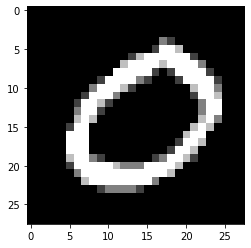

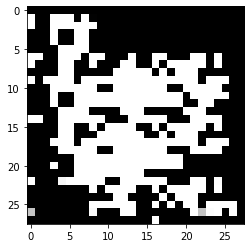

'epoch:  1501 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1242.7256  and acc:  0.0 ]
'epoch:  1502 ' [discriminator loss:  10.453911  and acc:  0.9433594 ] [generator loss:  2187.204  and acc:  0.0 ]
'epoch:  1503 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1768.3695  and acc:  0.0 ]
'epoch:  1504 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1305.1738  and acc:  0.0 ]
'epoch:  1505 ' [discriminator loss:  1.4125981  and acc:  0.9902344 ] [generator loss:  1075.4436  and acc:  0.00390625 ]
'epoch:  1506 ' [discriminator loss:  2.130519  and acc:  0.9785156 ] [generator loss:  1174.4374  and acc:  0.0 ]
'epoch:  1507 ' [discriminator loss:  1.4055772  and acc:  0.98828125 ] [generator loss:  968.5668  and acc:  0.00390625 ]
'epoch:  1508 ' [discriminator loss:  1.5221146  and acc:  0.9785156 ] [generator loss:  1178.5073  and acc:  0.0 ]
'epoch:  1509 ' [discriminator loss:  0.67296124  and acc:  0.98828125 ] [generator loss:  1061.

'epoch:  1574 ' [discriminator loss:  8.307763  and acc:  0.9238281 ] [generator loss:  1910.3481  and acc:  0.0 ]
'epoch:  1575 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1571.7922  and acc:  0.0 ]
'epoch:  1576 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1188.0702  and acc:  0.0 ]
'epoch:  1577 ' [discriminator loss:  8.5194984e-07  and acc:  1.0 ] [generator loss:  845.6687  and acc:  0.0 ]
'epoch:  1578 ' [discriminator loss:  6.639592  and acc:  0.9511719 ] [generator loss:  1498.7711  and acc:  0.0 ]
'epoch:  1579 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1200.6055  and acc:  0.0 ]
'epoch:  1580 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  876.13904  and acc:  0.0 ]
'epoch:  1581 ' [discriminator loss:  16.89527  and acc:  0.98046875 ] [generator loss:  604.8639  and acc:  0.03515625 ]
'epoch:  1582 ' [discriminator loss:  31.08677  and acc:  0.84375 ] [generator loss:  1697.0085  and acc:  0.0 ]
'epoch

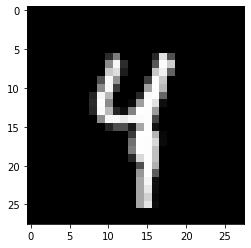

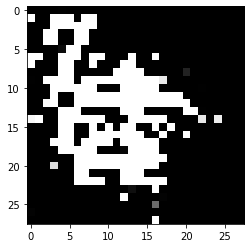

'epoch:  1601 ' [discriminator loss:  5.4229984  and acc:  0.9609375 ] [generator loss:  1322.0762  and acc:  0.00390625 ]
'epoch:  1602 ' [discriminator loss:  0.3940806  and acc:  0.9941406 ] [generator loss:  972.69147  and acc:  0.0 ]
'epoch:  1603 ' [discriminator loss:  4.9756374  and acc:  0.96875 ] [generator loss:  1162.8378  and acc:  0.00390625 ]
'epoch:  1604 ' [discriminator loss:  3.9436069  and acc:  0.9667969 ] [generator loss:  1360.9143  and acc:  0.00390625 ]
'epoch:  1605 ' [discriminator loss:  0.02164106  and acc:  0.9980469 ] [generator loss:  955.2334  and acc:  0.01171875 ]
'epoch:  1606 ' [discriminator loss:  10.230242  and acc:  0.9394531 ] [generator loss:  1846.8162  and acc:  0.0 ]
'epoch:  1607 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1394.9287  and acc:  0.0 ]
'epoch:  1608 ' [discriminator loss:  0.19107316  and acc:  0.99609375 ] [generator loss:  983.16174  and acc:  0.01171875 ]
'epoch:  1609 ' [discriminator loss:  10.782942  

'epoch:  1673 ' [discriminator loss:  30.622599  and acc:  0.8496094 ] [generator loss:  1395.0742  and acc:  0.0 ]
'epoch:  1674 ' [discriminator loss:  1.5235194  and acc:  0.9941406 ] [generator loss:  908.3849  and acc:  0.02734375 ]
'epoch:  1675 ' [discriminator loss:  30.122833  and acc:  0.875 ] [generator loss:  1368.057  and acc:  0.0 ]
'epoch:  1676 ' [discriminator loss:  7.1706443  and acc:  0.9589844 ] [generator loss:  1159.6677  and acc:  0.00390625 ]
'epoch:  1677 ' [discriminator loss:  20.10387  and acc:  0.9121094 ] [generator loss:  1351.7263  and acc:  0.0 ]
'epoch:  1678 ' [discriminator loss:  14.753306  and acc:  0.9375 ] [generator loss:  1389.4886  and acc:  0.0 ]
'epoch:  1679 ' [discriminator loss:  15.704496  and acc:  0.9394531 ] [generator loss:  1424.4878  and acc:  0.0078125 ]
'epoch:  1680 ' [discriminator loss:  13.955161  and acc:  0.9355469 ] [generator loss:  1528.1787  and acc:  0.0 ]
'epoch:  1681 ' [discriminator loss:  4.5480547  and acc:  0.9

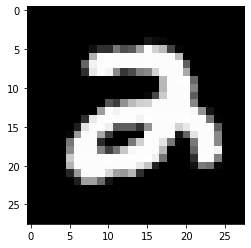

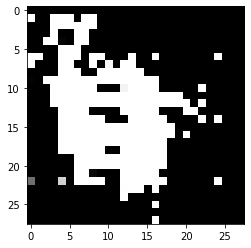

'epoch:  1701 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1603.263  and acc:  0.0 ]
'epoch:  1702 ' [discriminator loss:  2.1496518  and acc:  0.9863281 ] [generator loss:  1300.764  and acc:  0.0078125 ]
'epoch:  1703 ' [discriminator loss:  13.385331  and acc:  0.9472656 ] [generator loss:  1794.7905  and acc:  0.0 ]
'epoch:  1704 ' [discriminator loss:  0.27726552  and acc:  0.9980469 ] [generator loss:  1353.6761  and acc:  0.0 ]
'epoch:  1705 ' [discriminator loss:  10.811525  and acc:  0.94140625 ] [generator loss:  1931.2073  and acc:  0.0 ]
'epoch:  1706 ' [discriminator loss:  0.95450985  and acc:  0.99609375 ] [generator loss:  1452.2524  and acc:  0.0 ]
'epoch:  1707 ' [discriminator loss:  5.1933312  and acc:  0.9707031 ] [generator loss:  1574.916  and acc:  0.0 ]
'epoch:  1708 ' [discriminator loss:  3.546114  and acc:  0.97265625 ] [generator loss:  1561.4138  and acc:  0.0 ]
'epoch:  1709 ' [discriminator loss:  1.7851963  and acc:  0.9902344 ] [gener

'epoch:  1772 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1272.6964  and acc:  0.0 ]
'epoch:  1773 ' [discriminator loss:  6.128001  and acc:  0.96484375 ] [generator loss:  2438.288  and acc:  0.0 ]
'epoch:  1774 ' [discriminator loss:  22.662903  and acc:  0.9980469 ] [generator loss:  737.323  and acc:  0.0625 ]
'epoch:  1775 ' [discriminator loss:  126.09011  and acc:  0.7050781 ] [generator loss:  2440.6155  and acc:  0.0 ]
'epoch:  1776 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1932.8629  and acc:  0.0 ]
'epoch:  1777 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1466.0413  and acc:  0.0 ]
'epoch:  1778 ' [discriminator loss:  0.6166011  and acc:  0.9941406 ] [generator loss:  1010.0014  and acc:  0.01953125 ]
'epoch:  1779 ' [discriminator loss:  26.537601  and acc:  0.8730469 ] [generator loss:  1527.3984  and acc:  0.0 ]
'epoch:  1780 ' [discriminator loss:  2.671105  and acc:  0.984375 ] [generator loss:  985.6223  and 

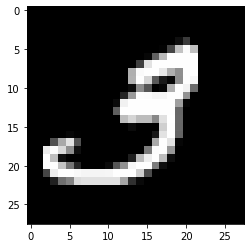

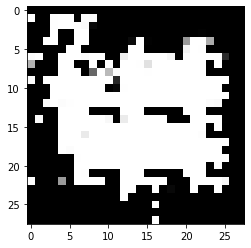

'epoch:  1801 ' [discriminator loss:  27.92886  and acc:  0.8574219 ] [generator loss:  2114.204  and acc:  0.0 ]
'epoch:  1802 ' [discriminator loss:  0.29372862  and acc:  0.99609375 ] [generator loss:  1331.4282  and acc:  0.00390625 ]
'epoch:  1803 ' [discriminator loss:  4.453965  and acc:  0.9667969 ] [generator loss:  1029.3237  and acc:  0.015625 ]
'epoch:  1804 ' [discriminator loss:  20.810762  and acc:  0.89453125 ] [generator loss:  1795.5935  and acc:  0.0 ]
'epoch:  1805 ' [discriminator loss:  0.09115888  and acc:  0.9980469 ] [generator loss:  1075.5088  and acc:  0.0 ]
'epoch:  1806 ' [discriminator loss:  20.071865  and acc:  0.90234375 ] [generator loss:  1618.8131  and acc:  0.0 ]
'epoch:  1807 ' [discriminator loss:  0.40925115  and acc:  0.9941406 ] [generator loss:  1043.1866  and acc:  0.01171875 ]
'epoch:  1808 ' [discriminator loss:  13.403721  and acc:  0.921875 ] [generator loss:  1378.9078  and acc:  0.0 ]
'epoch:  1809 ' [discriminator loss:  0.9951159  an

'epoch:  1871 ' [discriminator loss:  55.025665  and acc:  0.8730469 ] [generator loss:  2595.2441  and acc:  0.0 ]
'epoch:  1872 ' [discriminator loss:  5.39568  and acc:  0.98046875 ] [generator loss:  1819.1096  and acc:  0.01171875 ]
'epoch:  1873 ' [discriminator loss:  30.196445  and acc:  0.91796875 ] [generator loss:  2190.5122  and acc:  0.0 ]
'epoch:  1874 ' [discriminator loss:  11.057743  and acc:  0.9707031 ] [generator loss:  1711.6489  and acc:  0.03125 ]
'epoch:  1875 ' [discriminator loss:  63.835663  and acc:  0.8457031 ] [generator loss:  3298.5413  and acc:  0.0 ]
'epoch:  1876 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2093.7847  and acc:  0.0 ]
'epoch:  1877 ' [discriminator loss:  13.265511  and acc:  0.9609375 ] [generator loss:  1882.2849  and acc:  0.00390625 ]
'epoch:  1878 ' [discriminator loss:  26.38616  and acc:  0.9277344 ] [generator loss:  2215.495  and acc:  0.0078125 ]
'epoch:  1879 ' [discriminator loss:  7.986907  and acc:  0.97

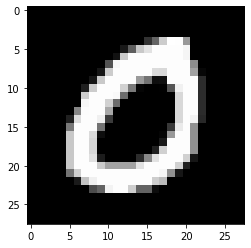

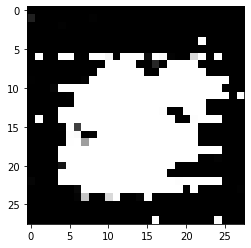

'epoch:  1901 ' [discriminator loss:  2.2026532  and acc:  0.9902344 ] [generator loss:  1855.1453  and acc:  0.00390625 ]
'epoch:  1902 ' [discriminator loss:  17.262072  and acc:  0.9609375 ] [generator loss:  2332.2683  and acc:  0.0 ]
'epoch:  1903 ' [discriminator loss:  1.7104218  and acc:  0.9921875 ] [generator loss:  1684.0625  and acc:  0.0078125 ]
'epoch:  1904 ' [discriminator loss:  18.674522  and acc:  0.9394531 ] [generator loss:  2985.75  and acc:  0.0 ]
'epoch:  1905 ' [discriminator loss:  1.0713832  and acc:  0.99609375 ] [generator loss:  2145.0312  and acc:  0.00390625 ]
'epoch:  1906 ' [discriminator loss:  3.838193  and acc:  0.9824219 ] [generator loss:  2032.3369  and acc:  0.0 ]
'epoch:  1907 ' [discriminator loss:  10.065952  and acc:  0.9746094 ] [generator loss:  2086.855  and acc:  0.0078125 ]
'epoch:  1908 ' [discriminator loss:  8.444134  and acc:  0.9609375 ] [generator loss:  2769.0015  and acc:  0.0 ]
'epoch:  1909 ' [discriminator loss:  1.5989742  a

'epoch:  1972 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2245.566  and acc:  0.0 ]
'epoch:  1973 ' [discriminator loss:  0.059170574  and acc:  0.99609375 ] [generator loss:  1980.7898  and acc:  0.0 ]
'epoch:  1974 ' [discriminator loss:  2.657541  and acc:  0.9902344 ] [generator loss:  2315.288  and acc:  0.0 ]
'epoch:  1975 ' [discriminator loss:  0.1409553  and acc:  0.9980469 ] [generator loss:  1884.4451  and acc:  0.0 ]
'epoch:  1976 ' [discriminator loss:  2.3082194  and acc:  0.9902344 ] [generator loss:  2207.9546  and acc:  0.00390625 ]
'epoch:  1977 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1669.5436  and acc:  0.0 ]
'epoch:  1978 ' [discriminator loss:  5.0766597  and acc:  0.9863281 ] [generator loss:  2187.7524  and acc:  0.0 ]
'epoch:  1979 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1610.6019  and acc:  0.00390625 ]
'epoch:  1980 ' [discriminator loss:  5.270315  and acc:  0.9785156 ] [generator loss:  2893.3

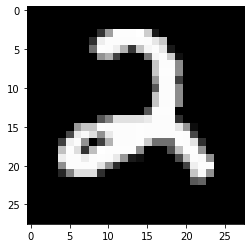

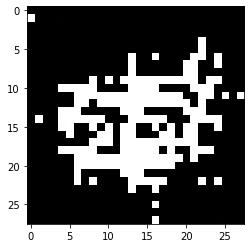

'epoch:  2001 ' [discriminator loss:  1.194393e-29  and acc:  1.0 ] [generator loss:  1443.543  and acc:  0.00390625 ]
'epoch:  2002 ' [discriminator loss:  7.719777  and acc:  0.9609375 ] [generator loss:  3541.4304  and acc:  0.0 ]
'epoch:  2003 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3005.9756  and acc:  0.0 ]
'epoch:  2004 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2418.1616  and acc:  0.0 ]
'epoch:  2005 ' [discriminator loss:  0.17101096  and acc:  0.9980469 ] [generator loss:  2049.2756  and acc:  0.0 ]
'epoch:  2006 ' [discriminator loss:  1.8944918  and acc:  0.9921875 ] [generator loss:  2357.2183  and acc:  0.0 ]
'epoch:  2007 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1914.0371  and acc:  0.0 ]
'epoch:  2008 ' [discriminator loss:  1.810798  and acc:  0.9902344 ] [generator loss:  2191.1472  and acc:  0.0 ]
'epoch:  2009 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1740.6978  and acc:  0.003906

'epoch:  2075 ' [discriminator loss:  0.8014157  and acc:  0.99609375 ] [generator loss:  1272.6873  and acc:  0.01953125 ]
'epoch:  2076 ' [discriminator loss:  11.199078  and acc:  0.94921875 ] [generator loss:  1868.2139  and acc:  0.0 ]
'epoch:  2077 ' [discriminator loss:  0.6096512  and acc:  0.9941406 ] [generator loss:  1385.2253  and acc:  0.0 ]
'epoch:  2078 ' [discriminator loss:  16.650095  and acc:  0.9394531 ] [generator loss:  2126.2515  and acc:  0.0 ]
'epoch:  2079 ' [discriminator loss:  3.522483e-21  and acc:  1.0 ] [generator loss:  1429.022  and acc:  0.0078125 ]
'epoch:  2080 ' [discriminator loss:  15.533386  and acc:  0.9433594 ] [generator loss:  2184.4482  and acc:  0.0 ]
'epoch:  2081 ' [discriminator loss:  3.3589335e-21  and acc:  1.0 ] [generator loss:  1330.7908  and acc:  0.01953125 ]
'epoch:  2082 ' [discriminator loss:  21.674114  and acc:  0.9160156 ] [generator loss:  2686.1836  and acc:  0.0 ]
'epoch:  2083 ' [discriminator loss:  0.0  and acc:  1.0

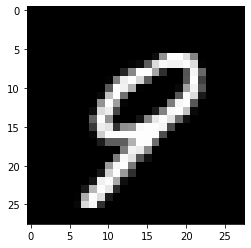

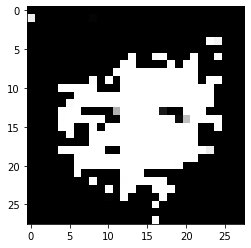

'epoch:  2101 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2015.9412  and acc:  0.0078125 ]
'epoch:  2102 ' [discriminator loss:  29.250202  and acc:  0.92578125 ] [generator loss:  3974.5303  and acc:  0.0 ]
'epoch:  2103 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2906.4983  and acc:  0.0 ]
'epoch:  2104 ' [discriminator loss:  8.165834e-25  and acc:  1.0 ] [generator loss:  2096.8086  and acc:  0.00390625 ]
'epoch:  2105 ' [discriminator loss:  20.395428  and acc:  0.9394531 ] [generator loss:  3317.0063  and acc:  0.0 ]
'epoch:  2106 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2629.1316  and acc:  0.0 ]
'epoch:  2107 ' [discriminator loss:  3.3566642  and acc:  0.984375 ] [generator loss:  2240.2458  and acc:  0.00390625 ]
'epoch:  2108 ' [discriminator loss:  4.439188  and acc:  0.984375 ] [generator loss:  2058.0095  and acc:  0.0 ]
'epoch:  2109 ' [discriminator loss:  13.859266  and acc:  0.9511719 ] [generator loss:  3243

'epoch:  2173 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2853.31  and acc:  0.0 ]
'epoch:  2174 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2084.858  and acc:  0.00390625 ]
'epoch:  2175 ' [discriminator loss:  1.8878716  and acc:  0.98828125 ] [generator loss:  2455.349  and acc:  0.0 ]
'epoch:  2176 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1880.8657  and acc:  0.00390625 ]
'epoch:  2177 ' [discriminator loss:  19.991394  and acc:  0.9433594 ] [generator loss:  4389.4014  and acc:  0.0 ]
'epoch:  2178 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3851.3147  and acc:  0.0 ]
'epoch:  2179 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3073.5833  and acc:  0.0 ]
'epoch:  2180 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2528.1526  and acc:  0.0 ]
'epoch:  2181 ' [discriminator loss:  0.137077  and acc:  0.99609375 ] [generator loss:  2062.8806  and acc:  0.00390625 ]
'epoch:  2

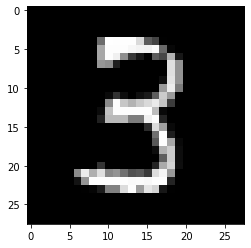

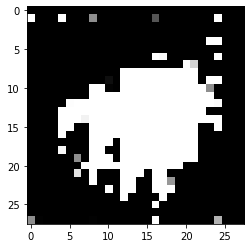

'epoch:  2201 ' [discriminator loss:  11.348872  and acc:  0.9628906 ] [generator loss:  3418.3574  and acc:  0.0 ]
'epoch:  2202 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2874.4692  and acc:  0.0 ]
'epoch:  2203 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2177.29  and acc:  0.0 ]
'epoch:  2204 ' [discriminator loss:  2.68266  and acc:  0.9941406 ] [generator loss:  2056.5435  and acc:  0.0 ]
'epoch:  2205 ' [discriminator loss:  2.3530374  and acc:  0.9902344 ] [generator loss:  2188.0493  and acc:  0.0 ]
'epoch:  2206 ' [discriminator loss:  0.7475678  and acc:  0.99609375 ] [generator loss:  1761.9622  and acc:  0.0078125 ]
'epoch:  2207 ' [discriminator loss:  5.2017546  and acc:  0.9785156 ] [generator loss:  2882.1533  and acc:  0.0 ]
'epoch:  2208 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2180.8364  and acc:  0.0 ]
'epoch:  2209 ' [discriminator loss:  0.7657096  and acc:  0.9980469 ] [generator loss:  1732.2728  and a

'epoch:  2274 ' [discriminator loss:  3.369759  and acc:  0.9824219 ] [generator loss:  1799.5413  and acc:  0.0 ]
'epoch:  2275 ' [discriminator loss:  1.4845386  and acc:  0.9863281 ] [generator loss:  1805.561  and acc:  0.0 ]
'epoch:  2276 ' [discriminator loss:  0.46995693  and acc:  0.99609375 ] [generator loss:  1315.0991  and acc:  0.00390625 ]
'epoch:  2277 ' [discriminator loss:  14.236139  and acc:  0.9355469 ] [generator loss:  3160.5776  and acc:  0.0 ]
'epoch:  2278 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2444.8223  and acc:  0.0 ]
'epoch:  2279 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  1694.5564  and acc:  0.0 ]
'epoch:  2280 ' [discriminator loss:  2.1422248  and acc:  0.984375 ] [generator loss:  1687.6748  and acc:  0.0 ]
'epoch:  2281 ' [discriminator loss:  0.9256464  and acc:  0.9921875 ] [generator loss:  1421.2839  and acc:  0.00390625 ]
'epoch:  2282 ' [discriminator loss:  13.66863  and acc:  0.9375 ] [generator loss:

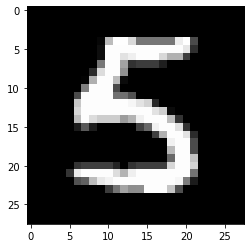

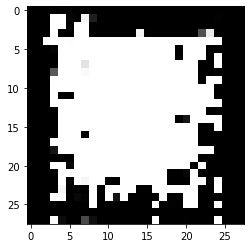

'epoch:  2301 ' [discriminator loss:  0.33481276  and acc:  0.99609375 ] [generator loss:  1681.3071  and acc:  0.0 ]
'epoch:  2302 ' [discriminator loss:  5.422097  and acc:  0.9707031 ] [generator loss:  1910.5769  and acc:  0.00390625 ]
'epoch:  2303 ' [discriminator loss:  3.582833  and acc:  0.98046875 ] [generator loss:  1774.364  and acc:  0.00390625 ]
'epoch:  2304 ' [discriminator loss:  8.015859  and acc:  0.9667969 ] [generator loss:  2112.3086  and acc:  0.0 ]
'epoch:  2305 ' [discriminator loss:  0.9102045  and acc:  0.9921875 ] [generator loss:  1666.7571  and acc:  0.0 ]
'epoch:  2306 ' [discriminator loss:  8.455499  and acc:  0.9550781 ] [generator loss:  2494.7166  and acc:  0.0 ]
'epoch:  2307 ' [discriminator loss:  3.8299714e-16  and acc:  1.0 ] [generator loss:  1799.2429  and acc:  0.0 ]
'epoch:  2308 ' [discriminator loss:  8.140242  and acc:  0.9707031 ] [generator loss:  2115.689  and acc:  0.0 ]
'epoch:  2309 ' [discriminator loss:  0.23484375  and acc:  0.99

'epoch:  2373 ' [discriminator loss:  2.1409888  and acc:  0.9863281 ] [generator loss:  2250.125  and acc:  0.0 ]
'epoch:  2374 ' [discriminator loss:  0.14545196  and acc:  0.9980469 ] [generator loss:  1720.0635  and acc:  0.0 ]
'epoch:  2375 ' [discriminator loss:  10.704512  and acc:  0.96875 ] [generator loss:  1479.6387  and acc:  0.0078125 ]
'epoch:  2376 ' [discriminator loss:  93.281525  and acc:  0.79296875 ] [generator loss:  4395.8545  and acc:  0.0 ]
'epoch:  2377 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3371.3418  and acc:  0.0 ]
'epoch:  2378 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2493.9739  and acc:  0.0 ]
'epoch:  2379 ' [discriminator loss:  4.833951  and acc:  0.9785156 ] [generator loss:  2267.5996  and acc:  0.0078125 ]
'epoch:  2380 ' [discriminator loss:  8.194454  and acc:  0.9746094 ] [generator loss:  2051.4312  and acc:  0.0 ]
'epoch:  2381 ' [discriminator loss:  6.7741284  and acc:  0.96875 ] [generator loss:  

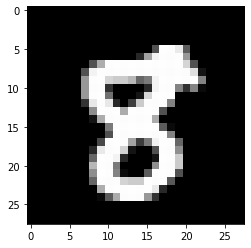

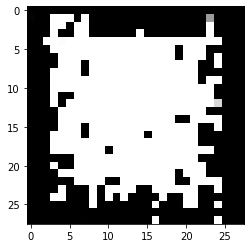

'epoch:  2401 ' [discriminator loss:  15.8447  and acc:  0.9472656 ] [generator loss:  2756.6826  and acc:  0.00390625 ]
'epoch:  2402 ' [discriminator loss:  0.027940033  and acc:  0.9980469 ] [generator loss:  1932.261  and acc:  0.0078125 ]
'epoch:  2403 ' [discriminator loss:  7.248673  and acc:  0.9589844 ] [generator loss:  2598.438  and acc:  0.0 ]
'epoch:  2404 ' [discriminator loss:  1.3258126  and acc:  0.9921875 ] [generator loss:  1880.2515  and acc:  0.0 ]
'epoch:  2405 ' [discriminator loss:  27.521372  and acc:  0.9199219 ] [generator loss:  3785.4941  and acc:  0.0 ]
'epoch:  2406 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2732.204  and acc:  0.0 ]
'epoch:  2407 ' [discriminator loss:  1.3083211e-36  and acc:  1.0 ] [generator loss:  1814.2632  and acc:  0.0 ]
'epoch:  2408 ' [discriminator loss:  33.16368  and acc:  0.8964844 ] [generator loss:  4705.285  and acc:  0.0 ]
'epoch:  2409 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  32

'epoch:  2472 ' [discriminator loss:  20.54842  and acc:  0.94921875 ] [generator loss:  2990.3896  and acc:  0.0 ]
'epoch:  2473 ' [discriminator loss:  1.1259944  and acc:  0.9941406 ] [generator loss:  2176.7134  and acc:  0.01171875 ]
'epoch:  2474 ' [discriminator loss:  43.10136  and acc:  0.8964844 ] [generator loss:  4328.2534  and acc:  0.0 ]
'epoch:  2475 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3001.766  and acc:  0.0 ]
'epoch:  2476 ' [discriminator loss:  4.9242907  and acc:  0.9785156 ] [generator loss:  2527.8389  and acc:  0.00390625 ]
'epoch:  2477 ' [discriminator loss:  17.275982  and acc:  0.953125 ] [generator loss:  3103.9292  and acc:  0.0 ]
'epoch:  2478 ' [discriminator loss:  1.6398624  and acc:  0.9921875 ] [generator loss:  2320.8462  and acc:  0.01171875 ]
'epoch:  2479 ' [discriminator loss:  32.36893  and acc:  0.9316406 ] [generator loss:  3561.5005  and acc:  0.0 ]
'epoch:  2480 ' [discriminator loss:  0.6754665  and acc:  0.996093

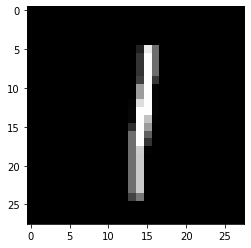

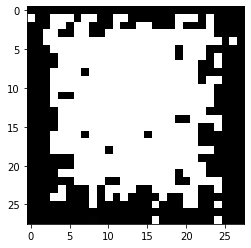

'epoch:  2501 ' [discriminator loss:  9.312441  and acc:  0.9667969 ] [generator loss:  3552.8418  and acc:  0.0 ]
'epoch:  2502 ' [discriminator loss:  1.1666926  and acc:  0.99609375 ] [generator loss:  2800.6577  and acc:  0.00390625 ]
'epoch:  2503 ' [discriminator loss:  11.513199  and acc:  0.9707031 ] [generator loss:  3581.8135  and acc:  0.0 ]
'epoch:  2504 ' [discriminator loss:  0.22654817  and acc:  0.9980469 ] [generator loss:  2513.1345  and acc:  0.00390625 ]
'epoch:  2505 ' [discriminator loss:  18.555208  and acc:  0.9628906 ] [generator loss:  3922.585  and acc:  0.0 ]
'epoch:  2506 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2756.774  and acc:  0.0 ]
'epoch:  2507 ' [discriminator loss:  15.410864  and acc:  0.9667969 ] [generator loss:  4041.2297  and acc:  0.0 ]
'epoch:  2508 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  2729.3008  and acc:  0.0078125 ]
'epoch:  2509 ' [discriminator loss:  27.937105  and acc:  0.9375 ] [generato

'epoch:  2574 ' [discriminator loss:  0.8517032  and acc:  0.9941406 ] [generator loss:  2935.3164  and acc:  0.00390625 ]
'epoch:  2575 ' [discriminator loss:  21.827461  and acc:  0.9628906 ] [generator loss:  5635.8105  and acc:  0.0 ]
'epoch:  2576 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4506.9146  and acc:  0.0 ]
'epoch:  2577 ' [discriminator loss:  3.814031e-11  and acc:  1.0 ] [generator loss:  3120.294  and acc:  0.0 ]
'epoch:  2578 ' [discriminator loss:  12.824962  and acc:  0.9609375 ] [generator loss:  5767.1606  and acc:  0.0 ]
'epoch:  2579 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4537.5503  and acc:  0.0 ]
'epoch:  2580 ' [discriminator loss:  0.15980029  and acc:  0.9980469 ] [generator loss:  3436.8044  and acc:  0.00390625 ]
'epoch:  2581 ' [discriminator loss:  4.526529  and acc:  0.9824219 ] [generator loss:  4548.301  and acc:  0.0 ]
'epoch:  2582 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3273.4744 

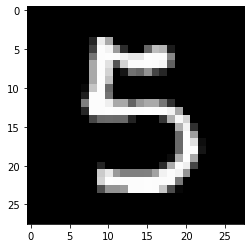

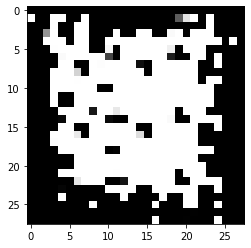

'epoch:  2601 ' [discriminator loss:  0.8871961  and acc:  0.9980469 ] [generator loss:  3302.5764  and acc:  0.0 ]
'epoch:  2602 ' [discriminator loss:  6.3023577  and acc:  0.9824219 ] [generator loss:  3922.2046  and acc:  0.0 ]
'epoch:  2603 ' [discriminator loss:  0.40268996  and acc:  0.9980469 ] [generator loss:  3076.6243  and acc:  0.0078125 ]
'epoch:  2604 ' [discriminator loss:  14.137385  and acc:  0.9609375 ] [generator loss:  5532.283  and acc:  0.0 ]
'epoch:  2605 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4493.166  and acc:  0.0 ]
'epoch:  2606 ' [discriminator loss:  1.994529  and acc:  0.99609375 ] [generator loss:  3479.731  and acc:  0.0078125 ]
'epoch:  2607 ' [discriminator loss:  0.41607326  and acc:  0.99609375 ] [generator loss:  2644.1628  and acc:  0.0078125 ]
'epoch:  2608 ' [discriminator loss:  42.317947  and acc:  0.9238281 ] [generator loss:  7376.2285  and acc:  0.0 ]
'epoch:  2609 ' [discriminator loss:  0.0  and acc:  1.0 ] [genera

'epoch:  2674 ' [discriminator loss:  7.569795  and acc:  0.9746094 ] [generator loss:  4523.328  and acc:  0.0 ]
'epoch:  2675 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3291.3813  and acc:  0.00390625 ]
'epoch:  2676 ' [discriminator loss:  1.2299972  and acc:  0.9941406 ] [generator loss:  2814.0986  and acc:  0.015625 ]
'epoch:  2677 ' [discriminator loss:  29.394527  and acc:  0.9375 ] [generator loss:  6602.1963  and acc:  0.0 ]
'epoch:  2678 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5347.6875  and acc:  0.0 ]
'epoch:  2679 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4214.309  and acc:  0.0 ]
'epoch:  2680 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3077.0002  and acc:  0.0 ]
'epoch:  2681 ' [discriminator loss:  14.546501  and acc:  0.97265625 ] [generator loss:  4372.533  and acc:  0.0 ]
'epoch:  2682 ' [discriminator loss:  0.060147747  and acc:  0.9980469 ] [generator loss:  3202.749  and acc:  0.0

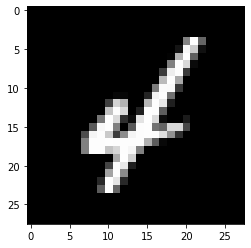

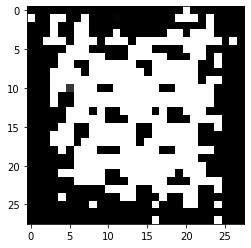

'epoch:  2701 ' [discriminator loss:  4.77896  and acc:  0.9824219 ] [generator loss:  4303.278  and acc:  0.0 ]
'epoch:  2702 ' [discriminator loss:  0.018448096  and acc:  0.9980469 ] [generator loss:  3385.3896  and acc:  0.0 ]
'epoch:  2703 ' [discriminator loss:  8.222795  and acc:  0.9824219 ] [generator loss:  4755.624  and acc:  0.0 ]
'epoch:  2704 ' [discriminator loss:  0.5694233  and acc:  0.99609375 ] [generator loss:  4014.5542  and acc:  0.0 ]
'epoch:  2705 ' [discriminator loss:  0.58017695  and acc:  0.99609375 ] [generator loss:  3260.8276  and acc:  0.00390625 ]
'epoch:  2706 ' [discriminator loss:  13.22978  and acc:  0.9746094 ] [generator loss:  5436.01  and acc:  0.0 ]
'epoch:  2707 ' [discriminator loss:  4.155779e-34  and acc:  1.0 ] [generator loss:  4223.049  and acc:  0.0 ]
'epoch:  2708 ' [discriminator loss:  1.2428544  and acc:  0.9941406 ] [generator loss:  3900.6733  and acc:  0.0 ]
'epoch:  2709 ' [discriminator loss:  2.7299106  and acc:  0.9921875 ] [

'epoch:  2773 ' [discriminator loss:  1.1237733  and acc:  0.9921875 ] [generator loss:  3523.5967  and acc:  0.0 ]
'epoch:  2774 ' [discriminator loss:  4.8835726  and acc:  0.9863281 ] [generator loss:  3245.713  and acc:  0.00390625 ]
'epoch:  2775 ' [discriminator loss:  8.52078  and acc:  0.9707031 ] [generator loss:  4174.1074  and acc:  0.0 ]
'epoch:  2776 ' [discriminator loss:  1.631972  and acc:  0.9941406 ] [generator loss:  3192.7742  and acc:  0.00390625 ]
'epoch:  2777 ' [discriminator loss:  13.313444  and acc:  0.97265625 ] [generator loss:  4119.008  and acc:  0.0 ]
'epoch:  2778 ' [discriminator loss:  7.70983e-34  and acc:  1.0 ] [generator loss:  2822.7046  and acc:  0.0078125 ]
'epoch:  2779 ' [discriminator loss:  42.853184  and acc:  0.9296875 ] [generator loss:  6945.241  and acc:  0.0 ]
'epoch:  2780 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5047.766  and acc:  0.0 ]
'epoch:  2781 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss

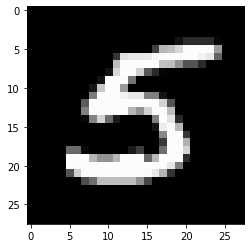

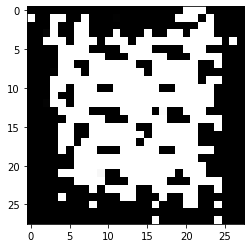

'epoch:  2801 ' [discriminator loss:  1.157326  and acc:  0.9941406 ] [generator loss:  3259.3406  and acc:  0.0 ]
'epoch:  2802 ' [discriminator loss:  12.137058  and acc:  0.9707031 ] [generator loss:  4779.0703  and acc:  0.0 ]
'epoch:  2803 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3608.5098  and acc:  0.0 ]
'epoch:  2804 ' [discriminator loss:  6.5386024  and acc:  0.9863281 ] [generator loss:  3412.0684  and acc:  0.0 ]
'epoch:  2805 ' [discriminator loss:  0.00014816505  and acc:  1.0 ] [generator loss:  2245.0247  and acc:  0.0234375 ]
'epoch:  2806 ' [discriminator loss:  36.754593  and acc:  0.9160156 ] [generator loss:  6969.8965  and acc:  0.0 ]
'epoch:  2807 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5753.7275  and acc:  0.0 ]
'epoch:  2808 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4553.504  and acc:  0.0 ]
'epoch:  2809 ' [discriminator loss:  1.051434  and acc:  0.99609375 ] [generator loss:  3573.466  and acc

'epoch:  2873 ' [discriminator loss:  43.051704  and acc:  0.9375 ] [generator loss:  7935.634  and acc:  0.0 ]
'epoch:  2874 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6430.8887  and acc:  0.0 ]
'epoch:  2875 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5139.519  and acc:  0.0 ]
'epoch:  2876 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3822.1758  and acc:  0.0 ]
'epoch:  2877 ' [discriminator loss:  3.3725772  and acc:  0.9902344 ] [generator loss:  3482.2188  and acc:  0.00390625 ]
'epoch:  2878 ' [discriminator loss:  17.928127  and acc:  0.9609375 ] [generator loss:  6185.5293  and acc:  0.0 ]
'epoch:  2879 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4864.8823  and acc:  0.0 ]
'epoch:  2880 ' [discriminator loss:  0.5152933  and acc:  0.9921875 ] [generator loss:  3984.5098  and acc:  0.0 ]
'epoch:  2881 ' [discriminator loss:  4.55219  and acc:  0.9863281 ] [generator loss:  4029.585  and acc:  0.0 ]
'epoc

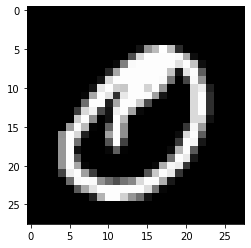

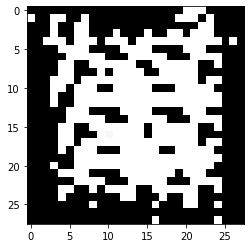

'epoch:  2901 ' [discriminator loss:  6.6694074  and acc:  0.9902344 ] [generator loss:  3705.295  and acc:  0.0 ]
'epoch:  2902 ' [discriminator loss:  8.593449  and acc:  0.9746094 ] [generator loss:  5325.1313  and acc:  0.0 ]
'epoch:  2903 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4151.913  and acc:  0.0 ]
'epoch:  2904 ' [discriminator loss:  3.782507  and acc:  0.9921875 ] [generator loss:  3462.7168  and acc:  0.00390625 ]
'epoch:  2905 ' [discriminator loss:  18.919487  and acc:  0.9707031 ] [generator loss:  5979.504  and acc:  0.0 ]
'epoch:  2906 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4415.542  and acc:  0.0 ]
'epoch:  2907 ' [discriminator loss:  3.1795063  and acc:  0.9941406 ] [generator loss:  3895.7104  and acc:  0.0 ]
'epoch:  2908 ' [discriminator loss:  6.494523  and acc:  0.98046875 ] [generator loss:  5173.8706  and acc:  0.0 ]
'epoch:  2909 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3813.2847  and acc

'epoch:  2974 ' [discriminator loss:  1.5520802  and acc:  0.9921875 ] [generator loss:  3517.737  and acc:  0.0 ]
'epoch:  2975 ' [discriminator loss:  8.743683  and acc:  0.9824219 ] [generator loss:  3571.5107  and acc:  0.00390625 ]
'epoch:  2976 ' [discriminator loss:  15.329748  and acc:  0.9550781 ] [generator loss:  5742.6006  and acc:  0.0 ]
'epoch:  2977 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4122.215  and acc:  0.0 ]
'epoch:  2978 ' [discriminator loss:  7.4669104  and acc:  0.984375 ] [generator loss:  4039.3174  and acc:  0.00390625 ]
'epoch:  2979 ' [discriminator loss:  9.053228  and acc:  0.984375 ] [generator loss:  3972.8955  and acc:  0.0 ]
'epoch:  2980 ' [discriminator loss:  9.416241  and acc:  0.98046875 ] [generator loss:  4349.0635  and acc:  0.0 ]
'epoch:  2981 ' [discriminator loss:  4.8177404  and acc:  0.9921875 ] [generator loss:  3807.713  and acc:  0.0 ]
'epoch:  2982 ' [discriminator loss:  16.813406  and acc:  0.9765625 ] [gener

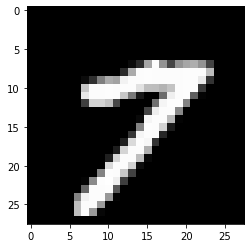

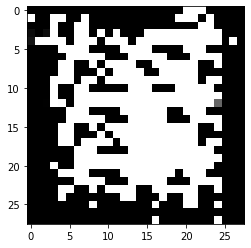

'epoch:  3001 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4250.581  and acc:  0.0 ]
'epoch:  3002 ' [discriminator loss:  12.2177105  and acc:  0.97265625 ] [generator loss:  5459.342  and acc:  0.0 ]
'epoch:  3003 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3954.8926  and acc:  0.00390625 ]
'epoch:  3004 ' [discriminator loss:  10.229366  and acc:  0.9785156 ] [generator loss:  4903.839  and acc:  0.0 ]
'epoch:  3005 ' [discriminator loss:  0.47303653  and acc:  0.99609375 ] [generator loss:  3784.9438  and acc:  0.01171875 ]
'epoch:  3006 ' [discriminator loss:  16.099195  and acc:  0.9589844 ] [generator loss:  6935.545  and acc:  0.0 ]
'epoch:  3007 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5387.4844  and acc:  0.0 ]
'epoch:  3008 ' [discriminator loss:  3.7294762  and acc:  0.9921875 ] [generator loss:  4670.5117  and acc:  0.0 ]
'epoch:  3009 ' [discriminator loss:  2.777224  and acc:  0.98828125 ] [generator loss:  4486.

'epoch:  3074 ' [discriminator loss:  5.9152327  and acc:  0.9921875 ] [generator loss:  5125.4775  and acc:  0.0 ]
'epoch:  3075 ' [discriminator loss:  1.4409775  and acc:  0.99609375 ] [generator loss:  4921.551  and acc:  0.0 ]
'epoch:  3076 ' [discriminator loss:  7.5017776  and acc:  0.98046875 ] [generator loss:  8806.623  and acc:  0.0 ]
'epoch:  3077 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7111.4443  and acc:  0.0 ]
'epoch:  3078 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5153.551  and acc:  0.0 ]
'epoch:  3079 ' [discriminator loss:  3.353593  and acc:  0.9921875 ] [generator loss:  5929.4756  and acc:  0.0 ]
'epoch:  3080 ' [discriminator loss:  0.9894887  and acc:  0.9941406 ] [generator loss:  6437.631  and acc:  0.0 ]
'epoch:  3081 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4715.7163  and acc:  0.0 ]
'epoch:  3082 ' [discriminator loss:  6.1232166  and acc:  0.984375 ] [generator loss:  7603.1807  and acc:  0.

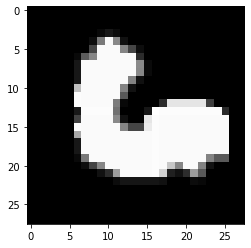

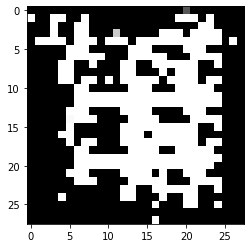

'epoch:  3101 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4339.0566  and acc:  0.015625 ]
'epoch:  3102 ' [discriminator loss:  19.157425  and acc:  0.98046875 ] [generator loss:  9202.275  and acc:  0.0 ]
'epoch:  3103 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7379.218  and acc:  0.0 ]
'epoch:  3104 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5375.416  and acc:  0.0 ]
'epoch:  3105 ' [discriminator loss:  3.3264995  and acc:  0.9941406 ] [generator loss:  6548.0522  and acc:  0.0 ]
'epoch:  3106 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4420.1055  and acc:  0.0078125 ]
'epoch:  3107 ' [discriminator loss:  20.008167  and acc:  0.96875 ] [generator loss:  11023.607  and acc:  0.0 ]
'epoch:  3108 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  9388.039  and acc:  0.0 ]
'epoch:  3109 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8057.6973  and acc:  0.0 ]
'epoch:  3110 ' [discr

'epoch:  3174 ' [discriminator loss:  41.332302  and acc:  0.94140625 ] [generator loss:  9317.27  and acc:  0.0 ]
'epoch:  3175 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7076.941  and acc:  0.0 ]
'epoch:  3176 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5288.6055  and acc:  0.0 ]
'epoch:  3177 ' [discriminator loss:  8.679176  and acc:  0.9824219 ] [generator loss:  5222.2617  and acc:  0.0 ]
'epoch:  3178 ' [discriminator loss:  13.266024  and acc:  0.97265625 ] [generator loss:  6137.699  and acc:  0.0 ]
'epoch:  3179 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4139.1895  and acc:  0.0 ]
'epoch:  3180 ' [discriminator loss:  13.232965  and acc:  0.96875 ] [generator loss:  5665.65  and acc:  0.0 ]
'epoch:  3181 ' [discriminator loss:  1.117176  and acc:  0.99609375 ] [generator loss:  4214.733  and acc:  0.0 ]
'epoch:  3182 ' [discriminator loss:  18.592972  and acc:  0.96484375 ] [generator loss:  6600.344  and acc:  0.0 ]


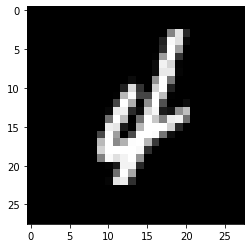

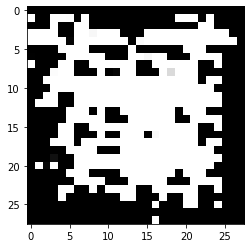

'epoch:  3201 ' [discriminator loss:  13.559114  and acc:  0.9863281 ] [generator loss:  1819.8579  and acc:  0.1953125 ]
'epoch:  3202 ' [discriminator loss:  739.2106  and acc:  0.6074219 ] [generator loss:  10576.428  and acc:  0.0 ]
'epoch:  3203 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7659.544  and acc:  0.0 ]
'epoch:  3204 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4647.8438  and acc:  0.0 ]
'epoch:  3205 ' [discriminator loss:  75.25959  and acc:  0.921875 ] [generator loss:  7175.826  and acc:  0.0 ]
'epoch:  3206 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4798.4966  and acc:  0.0 ]
'epoch:  3207 ' [discriminator loss:  23.08823  and acc:  0.9667969 ] [generator loss:  4244.4424  and acc:  0.00390625 ]
'epoch:  3208 ' [discriminator loss:  48.719307  and acc:  0.9296875 ] [generator loss:  5962.6963  and acc:  0.0 ]
'epoch:  3209 ' [discriminator loss:  1.838177  and acc:  0.9941406 ] [generator loss:  3881.574  and

'epoch:  3273 ' [discriminator loss:  22.002298  and acc:  0.96875 ] [generator loss:  4051.1216  and acc:  0.00390625 ]
'epoch:  3274 ' [discriminator loss:  16.939798  and acc:  0.97265625 ] [generator loss:  3561.5513  and acc:  0.00390625 ]
'epoch:  3275 ' [discriminator loss:  30.996727  and acc:  0.9433594 ] [generator loss:  5398.415  and acc:  0.0 ]
'epoch:  3276 ' [discriminator loss:  4.7229443  and acc:  0.9863281 ] [generator loss:  4237.178  and acc:  0.0 ]
'epoch:  3277 ' [discriminator loss:  22.851767  and acc:  0.953125 ] [generator loss:  5432.6367  and acc:  0.0 ]
'epoch:  3278 ' [discriminator loss:  1.1192969  and acc:  0.9941406 ] [generator loss:  3710.8394  and acc:  0.00390625 ]
'epoch:  3279 ' [discriminator loss:  62.257812  and acc:  0.9042969 ] [generator loss:  7858.0845  and acc:  0.0 ]
'epoch:  3280 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5476.756  and acc:  0.0 ]
'epoch:  3281 ' [discriminator loss:  5.1045074  and acc:  0.9863281

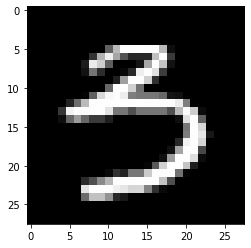

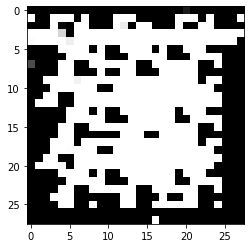

'epoch:  3301 ' [discriminator loss:  0.32909003  and acc:  0.9980469 ] [generator loss:  4525.8594  and acc:  0.01171875 ]
'epoch:  3302 ' [discriminator loss:  71.840935  and acc:  0.8984375 ] [generator loss:  6192.0806  and acc:  0.0 ]
'epoch:  3303 ' [discriminator loss:  3.6142519  and acc:  0.9941406 ] [generator loss:  3752.729  and acc:  0.01171875 ]
'epoch:  3304 ' [discriminator loss:  170.65106  and acc:  0.82421875 ] [generator loss:  7987.2363  and acc:  0.0 ]
'epoch:  3305 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6066.9883  and acc:  0.0 ]
'epoch:  3306 ' [discriminator loss:  5.113698  and acc:  0.9941406 ] [generator loss:  3756.15  and acc:  0.01953125 ]
'epoch:  3307 ' [discriminator loss:  84.17407  and acc:  0.9003906 ] [generator loss:  5496.9385  and acc:  0.0 ]
'epoch:  3308 ' [discriminator loss:  5.494637  and acc:  0.9902344 ] [generator loss:  3528.4338  and acc:  0.015625 ]
'epoch:  3309 ' [discriminator loss:  111.19342  and acc:  0.8

'epoch:  3373 ' [discriminator loss:  5.4649677  and acc:  0.98828125 ] [generator loss:  4366.2515  and acc:  0.00390625 ]
'epoch:  3374 ' [discriminator loss:  3.8747263  and acc:  0.984375 ] [generator loss:  4438.1284  and acc:  0.0078125 ]
'epoch:  3375 ' [discriminator loss:  23.018757  and acc:  0.9628906 ] [generator loss:  7103.1465  and acc:  0.0 ]
'epoch:  3376 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5026.4463  and acc:  0.0 ]
'epoch:  3377 ' [discriminator loss:  28.383696  and acc:  0.9609375 ] [generator loss:  8314.605  and acc:  0.0 ]
'epoch:  3378 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5704.547  and acc:  0.0 ]
'epoch:  3379 ' [discriminator loss:  35.166145  and acc:  0.96484375 ] [generator loss:  8564.276  and acc:  0.0 ]
'epoch:  3380 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6101.133  and acc:  0.0 ]
'epoch:  3381 ' [discriminator loss:  0.25453478  and acc:  0.99609375 ] [generator loss:  4760.56

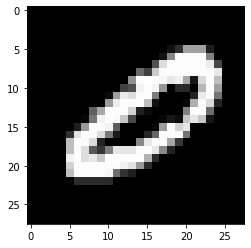

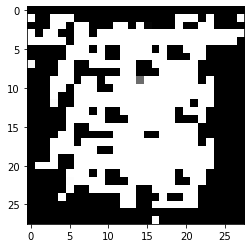

'epoch:  3401 ' [discriminator loss:  9.993973  and acc:  0.984375 ] [generator loss:  5895.9297  and acc:  0.0 ]
'epoch:  3402 ' [discriminator loss:  1.8806484  and acc:  0.9941406 ] [generator loss:  4853.224  and acc:  0.0 ]
'epoch:  3403 ' [discriminator loss:  22.05217  and acc:  0.9707031 ] [generator loss:  7820.064  and acc:  0.0 ]
'epoch:  3404 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5893.8564  and acc:  0.0 ]
'epoch:  3405 ' [discriminator loss:  5.328747  and acc:  0.9902344 ] [generator loss:  5553.89  and acc:  0.0 ]
'epoch:  3406 ' [discriminator loss:  6.124218  and acc:  0.9824219 ] [generator loss:  6569.131  and acc:  0.0 ]
'epoch:  3407 ' [discriminator loss:  0.34089097  and acc:  0.99609375 ] [generator loss:  5172.289  and acc:  0.0 ]
'epoch:  3408 ' [discriminator loss:  8.779503  and acc:  0.9765625 ] [generator loss:  7554.6406  and acc:  0.0 ]
'epoch:  3409 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5382.044  and acc

'epoch:  3474 ' [discriminator loss:  10.288874  and acc:  0.98046875 ] [generator loss:  7601.5303  and acc:  0.0 ]
'epoch:  3475 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5750.4697  and acc:  0.0 ]
'epoch:  3476 ' [discriminator loss:  1.5031823  and acc:  0.99609375 ] [generator loss:  5044.7393  and acc:  0.0 ]
'epoch:  3477 ' [discriminator loss:  13.485412  and acc:  0.9824219 ] [generator loss:  7460.0938  and acc:  0.0 ]
'epoch:  3478 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5822.6523  and acc:  0.0 ]
'epoch:  3479 ' [discriminator loss:  0.5909564  and acc:  0.9980469 ] [generator loss:  4332.0312  and acc:  0.00390625 ]
'epoch:  3480 ' [discriminator loss:  17.217934  and acc:  0.97265625 ] [generator loss:  9186.133  and acc:  0.0 ]
'epoch:  3481 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7021.6704  and acc:  0.0 ]
'epoch:  3482 ' [discriminator loss:  1.0142266  and acc:  0.9980469 ] [generator loss:  6045.162  

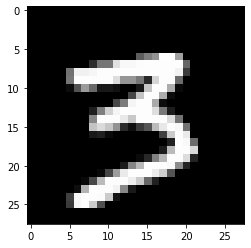

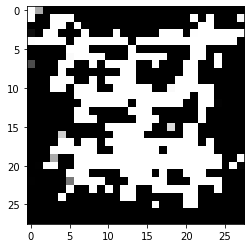

'epoch:  3501 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5296.356  and acc:  0.0 ]
'epoch:  3502 ' [discriminator loss:  3.8558607  and acc:  0.9902344 ] [generator loss:  5762.578  and acc:  0.0 ]
'epoch:  3503 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  3965.2598  and acc:  0.00390625 ]
'epoch:  3504 ' [discriminator loss:  76.56555  and acc:  0.9140625 ] [generator loss:  11824.26  and acc:  0.0 ]
'epoch:  3505 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  9572.305  and acc:  0.0 ]
'epoch:  3506 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8204.453  and acc:  0.0 ]
'epoch:  3507 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6896.9624  and acc:  0.0 ]
'epoch:  3508 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5123.448  and acc:  0.0 ]
'epoch:  3509 ' [discriminator loss:  6.568243  and acc:  0.98828125 ] [generator loss:  4895.325  and acc:  0.0 ]
'epoch:  3510 ' [discriminato

'epoch:  3575 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8469.571  and acc:  0.0 ]
'epoch:  3576 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6971.525  and acc:  0.0 ]
'epoch:  3577 ' [discriminator loss:  2.1317556  and acc:  0.9980469 ] [generator loss:  5524.371  and acc:  0.0 ]
'epoch:  3578 ' [discriminator loss:  4.64448  and acc:  0.9921875 ] [generator loss:  5900.4766  and acc:  0.0 ]
'epoch:  3579 ' [discriminator loss:  1.6167508  and acc:  0.99609375 ] [generator loss:  4776.2637  and acc:  0.00390625 ]
'epoch:  3580 ' [discriminator loss:  15.395615  and acc:  0.9746094 ] [generator loss:  9027.752  and acc:  0.0 ]
'epoch:  3581 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7129.247  and acc:  0.0 ]
'epoch:  3582 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5390.425  and acc:  0.0 ]
'epoch:  3583 ' [discriminator loss:  11.891108  and acc:  0.97265625 ] [generator loss:  9284.684  and acc:  0.0 ]
'epo

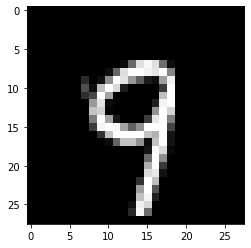

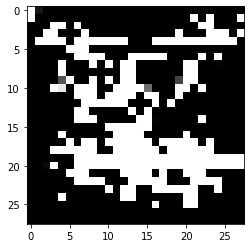

'epoch:  3601 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5573.831  and acc:  0.00390625 ]
'epoch:  3602 ' [discriminator loss:  0.92737734  and acc:  0.9921875 ] [generator loss:  5467.363  and acc:  0.0 ]
'epoch:  3603 ' [discriminator loss:  0.1477658  and acc:  0.99609375 ] [generator loss:  4592.3154  and acc:  0.0 ]
'epoch:  3604 ' [discriminator loss:  23.64721  and acc:  0.9667969 ] [generator loss:  8486.619  and acc:  0.0 ]
'epoch:  3605 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7009.4243  and acc:  0.0 ]
'epoch:  3606 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5470.346  and acc:  0.0 ]
'epoch:  3607 ' [discriminator loss:  4.541695  and acc:  0.9941406 ] [generator loss:  4926.5195  and acc:  0.0 ]
'epoch:  3608 ' [discriminator loss:  0.55504465  and acc:  0.9941406 ] [generator loss:  4949.49  and acc:  0.0 ]
'epoch:  3609 ' [discriminator loss:  6.605717  and acc:  0.9785156 ] [generator loss:  7367.351  and acc:

'epoch:  3675 ' [discriminator loss:  6.816776  and acc:  0.9902344 ] [generator loss:  6048.38  and acc:  0.00390625 ]
'epoch:  3676 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4550.047  and acc:  0.0 ]
'epoch:  3677 ' [discriminator loss:  54.629887  and acc:  0.9785156 ] [generator loss:  3027.546  and acc:  0.02734375 ]
'epoch:  3678 ' [discriminator loss:  191.7891  and acc:  0.8183594 ] [generator loss:  8177.9326  and acc:  0.0 ]
'epoch:  3679 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6315.609  and acc:  0.0 ]
'epoch:  3680 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  4856.9766  and acc:  0.0078125 ]
'epoch:  3681 ' [discriminator loss:  14.715778  and acc:  0.9785156 ] [generator loss:  3862.5325  and acc:  0.01953125 ]
'epoch:  3682 ' [discriminator loss:  113.47865  and acc:  0.8828125 ] [generator loss:  7030.462  and acc:  0.0 ]
'epoch:  3683 ' [discriminator loss:  2.3073559  and acc:  0.99609375 ] [generator loss: 

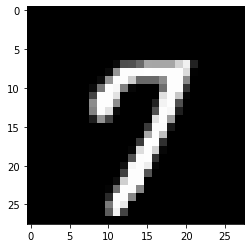

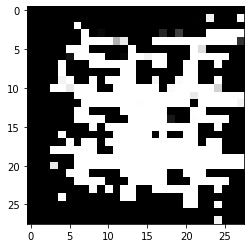

'epoch:  3701 ' [discriminator loss:  70.63892  and acc:  0.9042969 ] [generator loss:  9222.154  and acc:  0.0 ]
'epoch:  3702 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7140.875  and acc:  0.0 ]
'epoch:  3703 ' [discriminator loss:  7.2551055  and acc:  0.9941406 ] [generator loss:  5349.3945  and acc:  0.0078125 ]
'epoch:  3704 ' [discriminator loss:  86.651184  and acc:  0.91015625 ] [generator loss:  9376.646  and acc:  0.0 ]
'epoch:  3705 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7128.884  and acc:  0.0 ]
'epoch:  3706 ' [discriminator loss:  1.5815841  and acc:  0.9980469 ] [generator loss:  4679.95  and acc:  0.0 ]
'epoch:  3707 ' [discriminator loss:  69.498474  and acc:  0.9316406 ] [generator loss:  8701.434  and acc:  0.0 ]
'epoch:  3708 ' [discriminator loss:  3.9027383e-21  and acc:  1.0 ] [generator loss:  6267.006  and acc:  0.0 ]
'epoch:  3709 ' [discriminator loss:  0.4996131  and acc:  0.9980469 ] [generator loss:  4165.9624  

'epoch:  3773 ' [discriminator loss:  70.12048  and acc:  0.91796875 ] [generator loss:  5524.376  and acc:  0.0078125 ]
'epoch:  3774 ' [discriminator loss:  50.995148  and acc:  0.9394531 ] [generator loss:  5038.767  and acc:  0.01953125 ]
'epoch:  3775 ' [discriminator loss:  73.58981  and acc:  0.9355469 ] [generator loss:  5680.794  and acc:  0.00390625 ]
'epoch:  3776 ' [discriminator loss:  36.95867  and acc:  0.9550781 ] [generator loss:  4822.4897  and acc:  0.0078125 ]
'epoch:  3777 ' [discriminator loss:  82.09888  and acc:  0.9121094 ] [generator loss:  6937.583  and acc:  0.00390625 ]
'epoch:  3778 ' [discriminator loss:  10.9291  and acc:  0.984375 ] [generator loss:  5054.5835  and acc:  0.01171875 ]
'epoch:  3779 ' [discriminator loss:  67.900406  and acc:  0.93359375 ] [generator loss:  6120.671  and acc:  0.0078125 ]
'epoch:  3780 ' [discriminator loss:  36.06837  and acc:  0.9628906 ] [generator loss:  5866.7207  and acc:  0.015625 ]
'epoch:  3781 ' [discriminator l

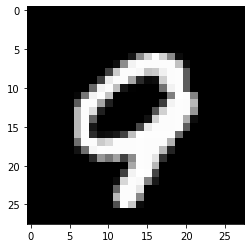

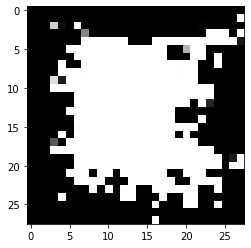

'epoch:  3801 ' [discriminator loss:  27.36588  and acc:  0.97265625 ] [generator loss:  6729.4575  and acc:  0.0 ]
'epoch:  3802 ' [discriminator loss:  24.306026  and acc:  0.9863281 ] [generator loss:  5045.2036  and acc:  0.0234375 ]
'epoch:  3803 ' [discriminator loss:  76.59679  and acc:  0.9121094 ] [generator loss:  11118.081  and acc:  0.0 ]
'epoch:  3804 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8769.781  and acc:  0.0 ]
'epoch:  3805 ' [discriminator loss:  0.23296162  and acc:  0.9980469 ] [generator loss:  6415.882  and acc:  0.0078125 ]
'epoch:  3806 ' [discriminator loss:  23.211195  and acc:  0.9746094 ] [generator loss:  6390.5225  and acc:  0.00390625 ]
'epoch:  3807 ' [discriminator loss:  18.803446  and acc:  0.9785156 ] [generator loss:  6532.781  and acc:  0.00390625 ]
'epoch:  3808 ' [discriminator loss:  19.859787  and acc:  0.9765625 ] [generator loss:  6790.2607  and acc:  0.0 ]
'epoch:  3809 ' [discriminator loss:  23.99821  and acc:  0.9

'epoch:  3873 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  9219.74  and acc:  0.0 ]
'epoch:  3874 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6760.387  and acc:  0.0 ]
'epoch:  3875 ' [discriminator loss:  29.849606  and acc:  0.96875 ] [generator loss:  10918.632  and acc:  0.0 ]
'epoch:  3876 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8757.013  and acc:  0.0 ]
'epoch:  3877 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6627.9385  and acc:  0.0078125 ]
'epoch:  3878 ' [discriminator loss:  1.2863537  and acc:  0.9980469 ] [generator loss:  4943.7734  and acc:  0.015625 ]
'epoch:  3879 ' [discriminator loss:  31.70773  and acc:  0.9609375 ] [generator loss:  9185.564  and acc:  0.0 ]
'epoch:  3880 ' [discriminator loss:  0.6941338  and acc:  0.9980469 ] [generator loss:  8006.6797  and acc:  0.00390625 ]
'epoch:  3881 ' [discriminator loss:  1.4115939  and acc:  0.99609375 ] [generator loss:  6059.2886  and acc: 

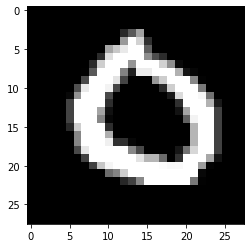

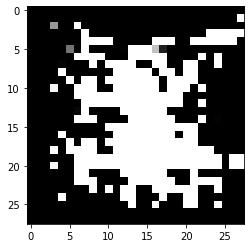

'epoch:  3901 ' [discriminator loss:  4.2058973  and acc:  0.9921875 ] [generator loss:  5841.871  and acc:  0.01171875 ]
'epoch:  3902 ' [discriminator loss:  6.899664  and acc:  0.9941406 ] [generator loss:  5222.9395  and acc:  0.015625 ]
'epoch:  3903 ' [discriminator loss:  25.37042  and acc:  0.9589844 ] [generator loss:  9868.249  and acc:  0.0 ]
'epoch:  3904 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8032.379  and acc:  0.0 ]
'epoch:  3905 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6245.694  and acc:  0.00390625 ]
'epoch:  3906 ' [discriminator loss:  6.376046  and acc:  0.9921875 ] [generator loss:  6259.156  and acc:  0.00390625 ]
'epoch:  3907 ' [discriminator loss:  19.012379  and acc:  0.98046875 ] [generator loss:  8134.0293  and acc:  0.0 ]
'epoch:  3908 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6301.919  and acc:  0.00390625 ]
'epoch:  3909 ' [discriminator loss:  9.246422  and acc:  0.984375 ] [generator los

'epoch:  3973 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  6302.8735  and acc:  0.0 ]
'epoch:  3974 ' [discriminator loss:  6.320229  and acc:  0.9902344 ] [generator loss:  7543.0825  and acc:  0.0 ]
'epoch:  3975 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5778.671  and acc:  0.0 ]
'epoch:  3976 ' [discriminator loss:  16.618649  and acc:  0.9785156 ] [generator loss:  9779.325  and acc:  0.0 ]
'epoch:  3977 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  7806.997  and acc:  0.0 ]
'epoch:  3978 ' [discriminator loss:  0.9859506  and acc:  0.9980469 ] [generator loss:  6753.8916  and acc:  0.00390625 ]
'epoch:  3979 ' [discriminator loss:  16.597075  and acc:  0.98046875 ] [generator loss:  9588.534  and acc:  0.0 ]
'epoch:  3980 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  8110.557  and acc:  0.0 ]
'epoch:  3981 ' [discriminator loss:  0.0  and acc:  1.0 ] [generator loss:  5697.323  and acc:  0.00390625 ]
'epoch: 

In [29]:
for epoch in range(4000):
    noise_input = np.random.uniform(-1, 1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise_input)

    for discriminator_epochs in range(1):
        genuine_images = X_train[np.random.randint(
            0, X_train.shape[0], size = batch_size), :, :, :]
        
        X_input = np.concatenate((genuine_images, fake_images))
        Y_label = np.ones([2 * batch_size, 1])
        Y_label[batch_size : , : ] = 0 

        d_loss = discriminator_compilation.train_on_batch(X_input, Y_label)
    
    Y_label = np.ones([batch_size, 1])
    g_loss = generator_compilation.train_on_batch(noise_input, Y_label)
    print("\'epoch: ", epoch,"\' [discriminator loss: ", d_loss[0], " and acc: ", d_loss[1],"] [generator loss: ",
          g_loss[0]," and acc: ", g_loss[1],"]")

    d_loss_tracker.append(d_loss[0])
    g_loss_tracker.append(g_loss[0])
    d_acc_tracker.append(d_loss[1])
    g_acc_tracker.append(g_loss[1])
    
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(genuine_images[0, :, :, 0], cmap='gray')
        plt.show()
        plt.imshow(fake_images[0, :, :, 0], cmap='gray')
        plt.show()